In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wrds
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats

## The Data

In [2]:
borisovadb=wrds.Connection()

In [ ]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1928-01-01'
            and mcaldt<='2004-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1928-01-01' and date<='2004-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})

#---------------------------------------------
# Stock Returns 
#---------------------------------------------
stock_data = db.raw_sql("""
                    select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1928' and '12/31/2004'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 
stock_data=stock_data.drop(['shrcd','exchcd'],axis=1)
stock_data = stock_data.rename(columns={'ret':'Rn'})
stock_data['mcap'] = np.abs(stock_data['prc'])*stock_data['shrout']
stock_data['mcap_l'] = stock_data.groupby(['permno'])['mcap'].shift(1)


#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(stock_data, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data.to_csv('data.csv', sep=';',index=False) # export data

## Betting against Beta strategy (BaB)

In [2]:
data_bab = pd.read_csv('data_with_siccd.csv', sep=',')
data_bab['date'] = pd.to_datetime(data_bab['date'])
data_bab=data_bab.sort_values(['date','permno']).reset_index(drop=True)
data_bab = data_bab.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data_bab['N'] = data_bab.groupby(['permno'])['date'].transform('count')
data_bab = data_bab[data_bab['N']>60].copy() # consider only those that have more than 5-years of data
data_bab.drop(columns=['Unnamed: 0'], inplace=True)
data_bab.sort_values('permno')

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N
1309232,10001,2016-08-31,11,2,4925,0.036620,10516.0,7.36,77397.76,80657.72,0.000199,0.002800,1,0.036421,0.002601,91
1267372,10001,2014-05-30,11,2,4925,-0.033486,10488.0,10.49,110019.12,110543.52,0.000019,0.020254,1,-0.033505,0.020235,91
1265826,10001,2014-04-30,11,2,4925,0.087972,10488.0,10.90,114319.20,110019.12,0.000008,0.001573,1,0.087964,0.001565,91
1264286,10001,2014-03-31,11,2,4925,0.079594,10452.0,10.06,105147.12,114319.20,0.000015,0.004540,1,0.079579,0.004525,91
1262756,10001,2014-02-28,11,2,4925,0.025627,10452.0,9.36,97830.72,105147.12,0.000025,0.046198,1,0.025602,0.046173,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301697,93426,2016-02-29,11,1,3676,-0.008460,12144.0,11.72,142327.68,170263.53,0.000186,0.000620,1,-0.008646,0.000434,160
1261228,93426,2013-12-31,11,1,3676,-0.124118,12709.0,14.89,189237.01,175840.16,0.000013,0.026140,1,-0.124131,0.026127,160
1318105,93426,2017-01-31,11,1,3676,-0.119048,12167.0,16.65,202580.55,539041.70,0.000393,0.022153,1,-0.119441,0.021760,160
1262755,93426,2014-01-31,11,1,3676,-0.043654,12709.0,14.24,180976.16,140949.24,0.000042,-0.030020,1,-0.043696,-0.030062,160


In [3]:
data_bab=data_bab.sort_values(['permno','date']).reset_index(drop=True)
data_bab['mcap_l'] = data_bab.groupby(['permno'])['mcap'].shift(1)
data_bab = data_bab.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

data_bab

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N
1,10001,2010-01-29,11,2,4925,-0.018932,4361.0,10.0600,43871.6600,44918.3000,0.000013,-0.037172,1,-0.018945,-0.037185,91
2,10001,2010-02-26,11,2,4925,-0.000656,4361.0,10.0084,43646.6324,43871.6600,0.000061,0.034744,1,-0.000717,0.034683,91
3,10001,2010-03-31,11,2,4925,0.020643,4361.0,10.1700,44351.3700,43646.6324,0.000112,0.063668,1,0.020531,0.063556,91
4,10001,2010-04-30,11,2,4925,0.124385,6070.0,11.3900,69137.3000,44351.3700,0.000118,0.020036,1,0.124267,0.019918,91
5,10001,2010-05-28,11,2,4925,0.004829,6071.0,11.4000,69209.4000,69137.3000,0.000114,-0.079240,1,0.004715,-0.079354,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321748,93426,2023-08-31,11,1,3676,-0.037156,12581.0,36.0200,453167.6200,470505.5700,0.004463,-0.020605,1,-0.041619,-0.025068,160
1321749,93426,2023-09-29,11,1,3676,-0.067740,12581.0,33.5800,422469.9800,453167.6200,0.004472,-0.047390,1,-0.072212,-0.051862,160
1321750,93426,2023-10-31,11,1,3676,-0.108993,12581.0,29.9200,376423.5200,422469.9800,0.004475,-0.028867,1,-0.113468,-0.033342,160
1321751,93426,2023-11-30,11,1,3676,0.019051,12510.0,30.4900,381429.9000,376423.5200,0.004455,0.092057,1,0.014596,0.087602,160


### Time-varying market Beta 

In [4]:
window_size = 60 # 5-year rolling window
#Compute covariance matrix of excess stock and market returns
cov_nm = data_bab.set_index('date').groupby('permno', sort=True)[['Rn_e','Rm_e']].rolling(window_size, min_periods=36).cov()
cov_nm
cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2)
# Compute beta from OLS regression (COV(Rn_e, Rm_e)/VAR(Rm_e))
beta = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta = beta.dropna()
beta = beta.reset_index().rename(columns={'Rm_e': 'beta'})

# Merge beta dataframe into data dataframe
beta = beta.set_index(['date', 'permno']).groupby('permno').shift(1)
beta = beta.dropna()
data_bab = pd.merge(data_bab, beta, on=['date','permno'], how='left')

# Winsorize the beta at 5 and 95%
data_bab['beta'] = data_bab['beta'].clip(lower = data_bab['beta'].quantile(0.05), upper = data_bab['beta'].quantile(0.95))
data_bab = data_bab.dropna(subset='beta').copy()

In [5]:
data_bab.date.nunique()

682

### Portfolio Sorts
#### Equall Weighted

In [6]:
# Compute beta decile for each date
data_bab['beta_decile'] = data_bab.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))
# Compute weight for equal-weight porfolio for each date-decile portfolio
data_bab['ew_decile'] = 1 / data_bab.groupby(['date','beta_decile'])['permno'].transform('count')

# Compute weighted return of each portfolio
data_bab['ew_decile_ret'] = data_bab['ew_decile'] * data_bab['Rn']
data_bab['ew_decile_excess_ret'] = data_bab['ew_decile'] * data_bab['Rn_e']
ret_ew = data_bab.groupby(['date','beta_decile'])['ew_decile_ret'].sum().reset_index()

# Compute excess return
ew_decile_excess_ret = data_bab.groupby(['date', 'beta_decile'])['ew_decile_excess_ret'].sum().reset_index(name='ew_decile_excess_ret')
ret_ew = ret_ew.merge(ew_decile_excess_ret, on=['date', 'beta_decile'])
ret_ew

,date,beta_decile,ew_decile_ret,ew_decile_excess_ret
0,1967-02-28,0,0.024773,0.021036
1,1967-02-28,1,0.030760,0.027023
2,1967-02-28,2,0.037112,0.033375
3,1967-02-28,3,0.032681,0.028944
4,1967-02-28,4,0.037702,0.033965
...,...,...,...,...
6599,2023-12-29,5,0.104857,0.100372
6600,2023-12-29,6,0.124116,0.119631
6601,2023-12-29,7,0.136347,0.131863
6602,2023-12-29,8,0.132276,0.127792


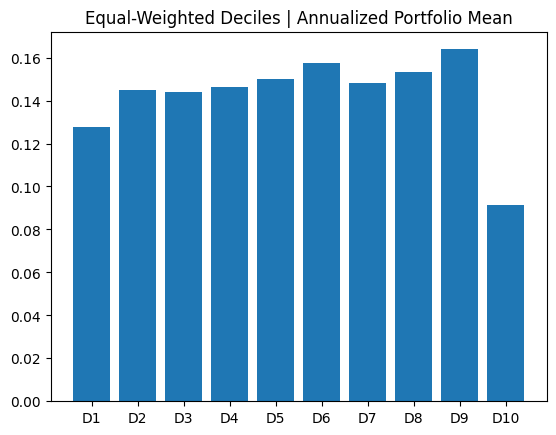

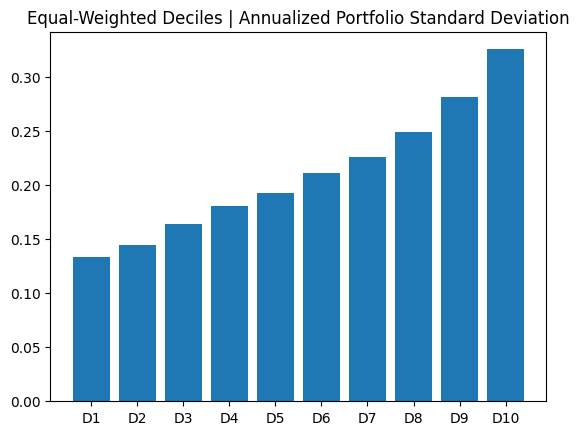

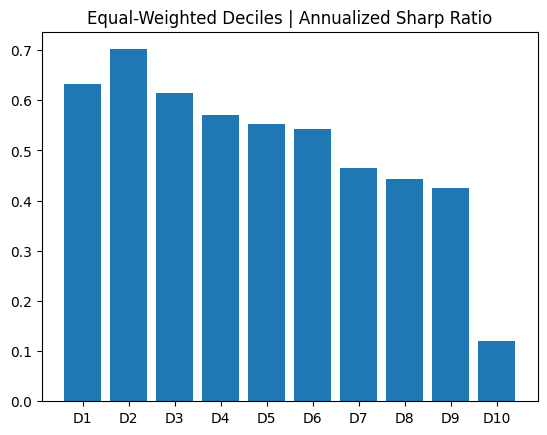

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [7]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('beta_decile')['ew_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew.groupby('beta_decile')['ew_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [8]:
data_bab = data_bab.dropna(subset='beta').copy()
data_bab['beta_decile'] = data_bab.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# Compute weights for value-weighted portfolios
data_bab['vw_decile'] = data_bab['mcap_l'] / data_bab.groupby(['date','beta_decile'])['mcap_l'].transform('sum')
# Compute returns for each portfolio
data_bab['vw_decile_ret'] = data_bab['vw_decile'] * data_bab['Rn']
data_bab['vw_decile_excess_ret'] = data_bab['vw_decile'] * data_bab['Rn_e']
ret_vw = data_bab.groupby(['date','beta_decile'])['vw_decile_ret'].sum().reset_index()
vw_decile_excess_ret = data_bab.groupby(['date', 'beta_decile'])['vw_decile_excess_ret'].sum().reset_index(name='vw_decile_excess_ret')
ret_vw = ret_vw.merge(vw_decile_excess_ret, on=['date', 'beta_decile'])
ret_vw

,date,beta_decile,vw_decile_ret,vw_decile_excess_ret
0,1967-02-28,0,0.009894,0.006157
1,1967-02-28,1,0.007510,0.003772
2,1967-02-28,2,0.027592,0.023855
3,1967-02-28,3,0.004571,0.000834
4,1967-02-28,4,-0.001519,-0.005257
...,...,...,...,...
6599,2023-12-29,5,0.078758,0.074274
6600,2023-12-29,6,0.089746,0.085261
6601,2023-12-29,7,0.108026,0.103542
6602,2023-12-29,8,0.116910,0.112425


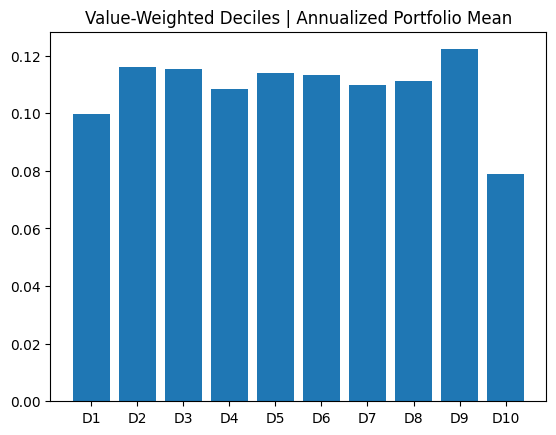

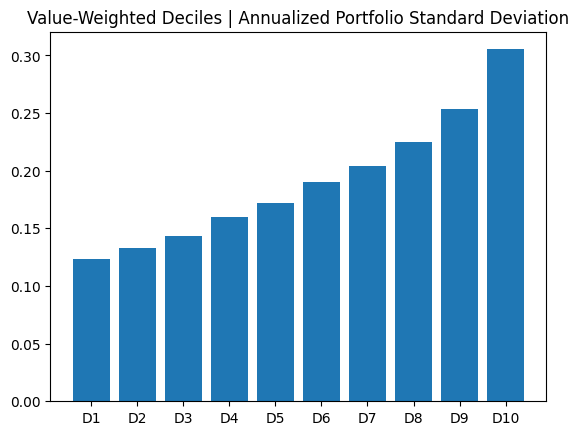

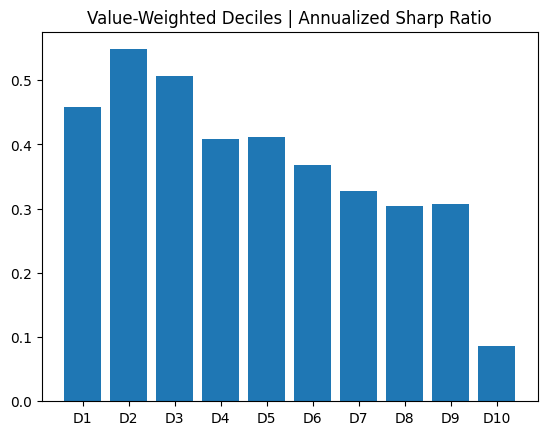

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [9]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('beta_decile')['vw_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw.groupby('beta_decile')['vw_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Constructing the BAB factor

In [10]:
# Compute z
data_bab['z'] = data_bab.groupby('date')['beta'].transform(lambda x: x.rank())
# Compute z-hat
data_bab['z_mean'] = data_bab.groupby('date')['z'].transform('mean')
# Calculate (z - z-hat)
data_bab['z_'] = data_bab['z'] - data_bab['z_mean']
# Calculate k
data_bab['k'] = np.abs(data_bab['z_'])
data_bab['k'] = 2/data_bab.groupby('date')['k'].transform('sum')
# Compute high-beta and low-beta portfolios weights
data_bab['w_H'] = data_bab['k'] * data_bab['z_'] * (data_bab['z_']>0) 
data_bab['w_L'] = -data_bab['k'] * data_bab['z_'] * (data_bab['z_']<0) 

In [11]:
# Compute betas
data_bab['beta_H'] = data_bab['w_H'] * data_bab['beta']
data_bab['beta_L'] = data_bab['w_L'] * data_bab['beta']
# Compute Excess Returns
data_bab['R_H_e'] = data_bab['w_H'] * data_bab['Rn_e']
data_bab['R_L_e'] = data_bab['w_L'] * data_bab['Rn_e']
# Sum up all returns and betas for each date
BAB = data_bab.groupby('date')[['R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
# Compute BAB return
BAB['R_BAB'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H'] 


In [12]:
tmp = pd.merge(BAB,data_bab[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['const'] = 1
tmp = tmp.dropna()
reg = sm.OLS(tmp['R_BAB'], tmp[['const', 'Rm_e']]).fit()

print('----------------------------------------')
print(f"| Annualized mean          | {np.round(tmp['R_BAB'].mean() * 12, 5)} |")
print(f"| Annualized std           | {np.round(tmp['R_BAB'].std() * np.sqrt(12), 5)}  |")
print(f"| Annualized Sharp Ratio   | {np.round(tmp['R_BAB'].mean() / tmp['R_BAB'].std() * np.sqrt(12), 5)} |")
print(f"| Annualized CAPM alpha    | {np.round(reg.params['const'] * 12, 5)} |")
print(f"| BAB factor               | {np.round(reg.params['Rm_e'], 5)} |")
print('----------------------------------------')

----------------------------------------
| Annualized mean          | 0.1147 |
| Annualized std           | 0.1403  |
| Annualized Sharp Ratio   | 0.81752 |
| Annualized CAPM alpha    | 0.08058 |
| BAB factor               | 0.51262 |
----------------------------------------


In [13]:
BAB_returns = tmp.set_index('date')['R_BAB']
BAB_returns

date
1967-02-28    0.016480
1967-03-31    0.006409
1967-04-28    0.020326
1967-05-31    0.003236
1967-06-30   -0.010238
                ...   
2023-08-31   -0.012749
2023-09-29   -0.042913
2023-10-31    0.003591
2023-11-30    0.037604
2023-12-29    0.002321
Name: R_BAB, Length: 682, dtype: float64

## Momentum Strategy (Mom)

In [14]:
data_mom = pd.read_csv('data_with_siccd.csv', sep=',')
data_mom['date'] = pd.to_datetime(data_mom['date'])
data_mom=data_mom.sort_values(['date','permno']).reset_index(drop=True)
data_mom = data_mom.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data_mom['N'] = data_mom.groupby(['permno'])['date'].transform('count')
data_mom = data_mom[data_mom['N']>60].copy() # consider only those that have more than 5-years of data
data_mom.drop(columns=['Unnamed: 0'], inplace=True)
data_mom

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N
0,10006,1964-01-31,10,1,3743,0.068548,2948.0,66.250,195305.000,202675.000,0.002873,0.025790,1,0.065675,0.022917,243
1,10014,1964-01-31,10,1,3714,0.000000,3369.0,2.875,9685.875,9685.875,0.002873,0.025790,1,-0.002873,0.022917,157
3,10057,1964-01-31,11,1,3541,0.069915,500.0,62.500,31250.000,33000.000,0.002873,0.025790,1,0.067042,0.022917,388
4,10102,1964-01-31,10,1,2813,0.029083,5032.0,57.500,289340.000,278018.000,0.002873,0.025790,1,0.026210,0.022917,170
5,10137,1964-01-31,11,1,4911,-0.007371,9338.0,50.500,471569.000,490245.000,0.002873,0.025790,1,-0.010244,0.022917,563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439403,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.120,720652.900,0.004484,0.053468,1,0.092698,0.048984,162
1439404,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.020,37635.700,0.004484,0.053468,1,-0.030095,0.048984,162
1439405,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.640,2896005.370,0.004484,0.053468,1,0.085617,0.048984,161
1439406,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.960,2537102.050,0.004484,0.053468,1,0.002745,0.048984,161


In [15]:
data_mom=data_mom.sort_values(['permno','date']).reset_index(drop=True)
data_mom['mcap_l'] = data_mom.groupby(['permno'])['mcap'].shift(1)
data_mom = data_mom.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

### Portfolio Sorts

In [16]:
# Compute cumulative return for each permco
tmp = data_mom.set_index('date').groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11,closed='left').sum()).reset_index()
tmp['Rn'] = tmp.groupby('permno')['Rn'].shift(1)
tmp = tmp.dropna()
tmp = tmp.reset_index().rename(columns={'Rn': 'lagged_11_month_ret'})
data_mom = pd.merge(data_mom, tmp, on=['date','permno'], how='left')
# Compute Deciles of returns for each date
data_mom['lagged_11_month_ret_decile'] = data_mom.groupby('date')['lagged_11_month_ret'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

C:\Users\Amirmahdi\AppData\Local\Temp\ipykernel_13016\238818871.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = data_mom.set_index('date').groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11,closed='left').sum()).reset_index()


#### Equally Weighted 

In [17]:
# Calculate weights for equal-weighted portfolios for date-decile pair
data_mom['ew_lagged_decile'] = 1 / data_mom.groupby(['date','lagged_11_month_ret_decile'])['permno'].transform('count')
# Compute returns of each portfolio
data_mom['ew_lagged_decile_ret'] = data_mom['ew_lagged_decile'] * data_mom['Rn']
data_mom['ew_lagged_decile_excess_ret'] = data_mom['ew_lagged_decile'] * data_mom['Rn_e']
ret_ew_lagged = data_mom.groupby(['date','lagged_11_month_ret_decile'])['ew_lagged_decile_ret'].sum().reset_index()
# Excess return
ew_lagged_decile_excess_ret = data_mom.groupby(['date', 'lagged_11_month_ret_decile'])['ew_lagged_decile_excess_ret'].sum().reset_index(name='ew_lagged_decile_excess_ret')
ret_ew_lagged = ret_ew_lagged.merge(ew_lagged_decile_excess_ret, on=['date', 'lagged_11_month_ret_decile'])
ret_ew_lagged

,date,lagged_11_month_ret_decile,ew_lagged_decile_ret,ew_lagged_decile_excess_ret
0,1965-02-26,0.0,0.032477,0.029269
1,1965-02-26,1.0,0.039791,0.036583
2,1965-02-26,2.0,0.032332,0.029124
3,1965-02-26,3.0,0.025593,0.022385
4,1965-02-26,4.0,0.023414,0.020206
...,...,...,...,...
7055,2023-12-29,5.0,0.072226,0.067742
7056,2023-12-29,6.0,0.083800,0.079316
7057,2023-12-29,7.0,0.066432,0.061948
7058,2023-12-29,8.0,0.073134,0.068650


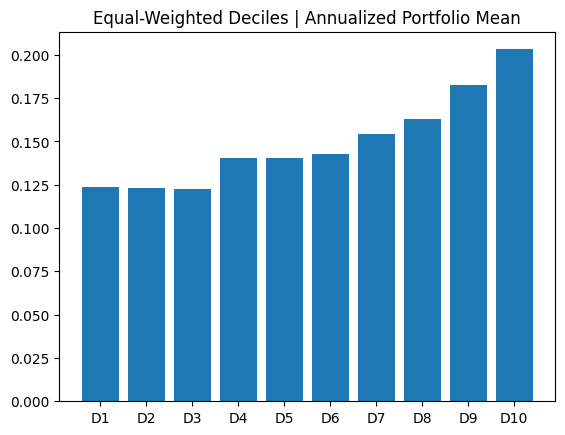

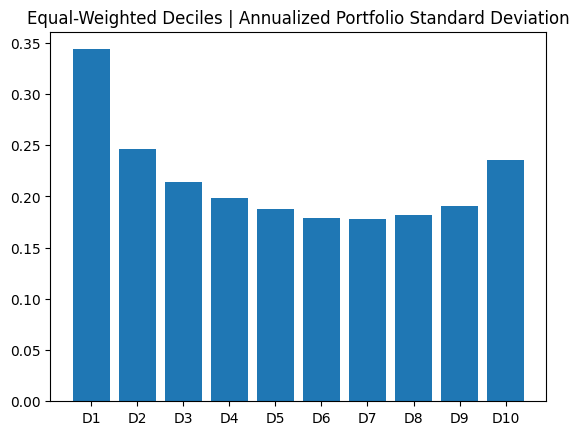

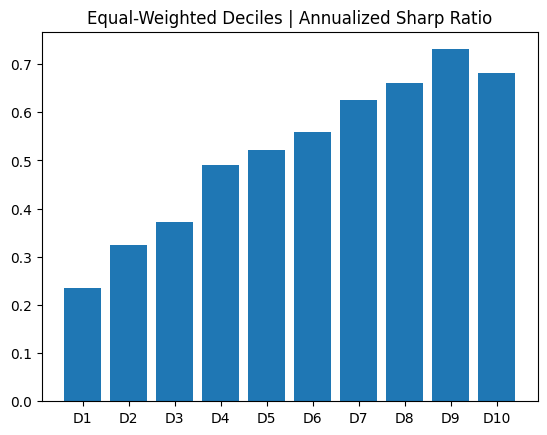

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [18]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew_lagged.groupby('lagged_11_month_ret_decile')['ew_lagged_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [19]:
# Compute weights for value-weighted portfolios
data_mom['vw_lagged_decile'] = data_mom['mcap_l'] / data_mom.groupby(['date','lagged_11_month_ret_decile'])['mcap_l'].transform('sum')
# Compute returns for each portfolio
data_mom['vw_lagged_decile_ret'] = data_mom['vw_lagged_decile'] * data_mom['Rn']
data_mom['vw_lagged_decile_excess_ret'] = data_mom['vw_lagged_decile'] * data_mom['Rn_e']
ret_vw_lagged = data_mom.groupby(['date','lagged_11_month_ret_decile'])['vw_lagged_decile_ret'].sum().reset_index()
vw_lagged_decile_excess_ret = data_mom.groupby(['date', 'lagged_11_month_ret_decile'])['vw_lagged_decile_excess_ret'].sum().reset_index(name='vw_lagged_decile_excess_ret')
ret_vw_lagged = ret_vw_lagged.merge(vw_lagged_decile_excess_ret, on=['date', 'lagged_11_month_ret_decile'])
ret_vw_lagged

,date,lagged_11_month_ret_decile,vw_lagged_decile_ret,vw_lagged_decile_excess_ret
0,1965-02-26,0.0,0.028314,0.025106
1,1965-02-26,1.0,0.021004,0.017797
2,1965-02-26,2.0,0.012000,0.008793
3,1965-02-26,3.0,0.020896,0.017689
4,1965-02-26,4.0,0.004111,0.000903
...,...,...,...,...
7055,2023-12-29,5.0,0.041202,0.036718
7056,2023-12-29,6.0,0.038512,0.034028
7057,2023-12-29,7.0,0.022200,0.017715
7058,2023-12-29,8.0,0.024981,0.020496


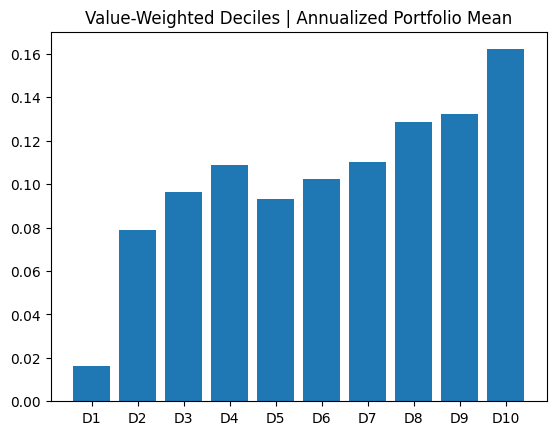

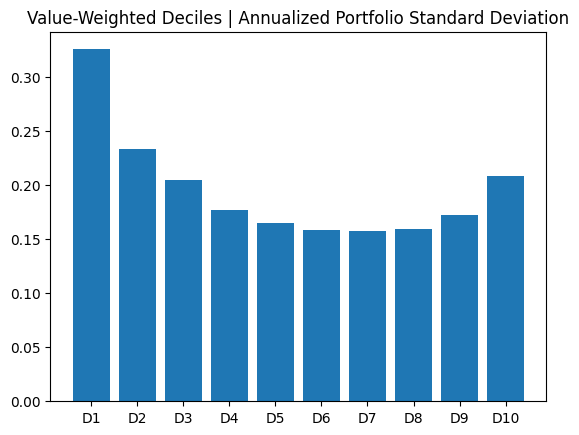

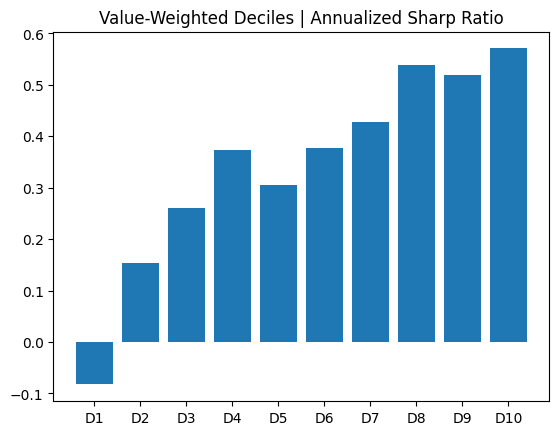

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [20]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw_lagged.groupby('lagged_11_month_ret_decile')['vw_lagged_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Momentum Strategy Portfolio

In [21]:
def calculate_portfolio_metrics(returns, excess_returns):
    mean_return = returns.mean() * 12
    std_dev = returns.std() * np.sqrt(12)
    sharpe_ratio = excess_returns.mean() * 12 / std_dev
    return mean_return, std_dev, sharpe_ratio

In [22]:
long_mom = data_mom[data_mom['lagged_11_month_ret_decile'].isin([7,8,9])].copy()
short_mom = data_mom[data_mom['lagged_11_month_ret_decile'].isin([0,1,2])].copy()

#### Equally Weighted Portfolio

In [23]:
# long_mom portfolio: Equal-weighted average of the top three deciles (Deciles 7, 8 and 9)
ew_long_mom_rets = long_mom.groupby('date')['Rn'].mean() 
ew_long_mom_excess_rets = long_mom.groupby('date')['Rn_e'].mean() 
# short_mom portfolio: Equal-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
ew_short_mom_rets = short_mom.groupby('date')['Rn'].mean() 
ew_short_mom_excess_rets = short_mom.groupby('date')['Rn_e'].mean() 
# Compute the return of the momentum strategy as the difference between the long_mom and short_mom portfolios' returns
ew_momentum_rets = ew_long_mom_rets - ew_short_mom_rets

In [24]:
ew_long_mom_mean, ew_long_mom_std, ew_long_mom_sharpe = calculate_portfolio_metrics(ew_long_mom_rets, ew_long_mom_excess_rets)
ew_short_mom_mean, ew_short_mom_std, ew_short_mom_sharpe = calculate_portfolio_metrics(ew_short_mom_rets, ew_short_mom_excess_rets)
ew_momentum_mean, ew_momentum_std, ew_momentum_sharpe = calculate_portfolio_metrics(ew_momentum_rets, ew_long_mom_excess_rets - ew_short_mom_excess_rets)
ew_t_stat, ew_p_value = stats.ttest_1samp(ew_momentum_rets, 0)

print(f"Equal-Weighted Portfolio Metrics:")
print(f"long_mom Portfolio: Mean = {ew_long_mom_mean:.3%}, Std Dev = {ew_long_mom_std:.3%}, Sharpe Ratio = {ew_long_mom_sharpe:.3f}")
print(f"short_mom Portfolio: Mean = {ew_short_mom_mean:.3%}, Std Dev = {ew_short_mom_std:.3%}, Sharpe Ratio = {ew_short_mom_sharpe:.3f}")
print(f"Momentum Strategy: Mean = {ew_momentum_mean:.3%}, Std Dev = {ew_momentum_std:.3%}, Sharpe Ratio = {ew_momentum_sharpe:.3f}")
print(f"T-statistic = {ew_t_stat:.2f}, P-value = {ew_p_value:.4f}\n")

Equal-Weighted Portfolio Metrics:
long_mom Portfolio: Mean = 18.294%, Std Dev = 19.882%, Sharpe Ratio = 0.704
short_mom Portfolio: Mean = 12.301%, Std Dev = 26.151%, Sharpe Ratio = 0.306
Momentum Strategy: Mean = 5.993%, Std Dev = 16.120%, Sharpe Ratio = 0.372
T-statistic = 2.85, P-value = 0.0045



#### Value Weighted Portfolio

In [25]:
# long_mom portfolio: Value-weighted average of the top three deciles (Deciles 7, 8 and 9)
long_mom_weights = long_mom['mcap_l'] / long_mom.groupby('date')['mcap_l'].transform('sum')
long_mom['vw_rets'] = long_mom_weights * long_mom['Rn']
vw_long_mom_rets = long_mom.groupby('date')['vw_rets'].sum()
long_mom['vw_excess_rets'] = long_mom_weights * long_mom['Rn_e']
vw_long_mom_excess_rets = long_mom.groupby('date')['vw_excess_rets'].sum()
# short_mom portfolio: Value-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
short_mom_weights = short_mom['mcap_l'] / short_mom.groupby('date')['mcap_l'].transform('sum')
short_mom['vw_rets'] = short_mom_weights * short_mom['Rn']
vw_short_mom_rets = short_mom.groupby('date')['vw_rets'].sum()
short_mom['vw_excess_rets'] = short_mom_weights * short_mom['Rn_e']
vw_short_mom_excess_rets = short_mom.groupby('date')['vw_excess_rets'].sum()
# Compute the return of the momentum strategy as the difference between the long_mom and short_mom portfolios' returns
vw_momentum_rets = vw_long_mom_rets - vw_short_mom_rets

In [26]:
vw_momentum_rets

date
1965-02-26   -0.005889
1965-03-31    0.005368
1965-04-30    0.026738
1965-05-28   -0.003614
1965-06-30   -0.047824
                ...   
2023-08-31    0.055875
2023-09-29    0.003078
2023-10-31   -0.022135
2023-11-30    0.025636
2023-12-29   -0.068551
Name: vw_rets, Length: 706, dtype: float64

In [27]:
MOM_returns = vw_momentum_rets.copy()

In [28]:
vw_long_mom_mean, vw_long_mom_std, vw_long_mom_sharpe = calculate_portfolio_metrics(vw_long_mom_rets, vw_long_mom_excess_rets)
vw_short_mom_mean, vw_short_mom_std, vw_short_mom_sharpe = calculate_portfolio_metrics(vw_short_mom_rets, vw_short_mom_excess_rets)
vw_momentum_mean, vw_momentum_std, vw_momentum_sharpe = calculate_portfolio_metrics(vw_momentum_rets, vw_long_mom_excess_rets - vw_short_mom_excess_rets)
vw_t_stat, vw_p_value = stats.ttest_1samp(vw_momentum_rets, 0)

print(f"Value-Weighted Portfolio Metrics:")
print(f"long_mom Portfolio: Mean = {vw_long_mom_mean:.3%}, Std Dev = {vw_long_mom_std:.3%}, Sharpe Ratio = {vw_long_mom_sharpe:.3f}")
print(f"short_mom Portfolio: Mean = {vw_short_mom_mean:.3%}, Std Dev = {vw_short_mom_std:.3%}, Sharpe Ratio = {vw_short_mom_sharpe:.3f}")
print(f"Momentum Strategy: Mean = {vw_momentum_mean:.3%}, Std Dev = {vw_momentum_std:.3%}, Sharpe Ratio = {vw_momentum_sharpe:.3f}")
print(f"T-statistic = {vw_t_stat:.2f}, P-value = {vw_p_value:.4f}\n")

Value-Weighted Portfolio Metrics:
long_mom Portfolio: Mean = 13.548%, Std Dev = 16.748%, Sharpe Ratio = 0.552
short_mom Portfolio: Mean = 8.177%, Std Dev = 21.984%, Sharpe Ratio = 0.176
Momentum Strategy: Mean = 5.370%, Std Dev = 16.979%, Sharpe Ratio = 0.316
T-statistic = 2.43, P-value = 0.0155



## Idiosyncratic Volatility Strategy (IV)

In [29]:
data_iv = pd.read_csv('data_with_siccd.csv', sep=',')
data_iv['date'] = pd.to_datetime(data_iv['date'])
data_iv=data_iv.sort_values(['date','permno']).reset_index(drop=True)
data_iv = data_iv.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data_iv['N'] = data_iv.groupby(['permno'])['date'].transform('count')
data_iv = data_iv[data_iv['N']>60].copy() # consider only those that have more than 5-years of data
data_iv.drop(columns=['Unnamed: 0'], inplace=True)
data_iv

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N
0,10006,1964-01-31,10,1,3743,0.068548,2948.0,66.250,195305.000,202675.000,0.002873,0.025790,1,0.065675,0.022917,243
1,10014,1964-01-31,10,1,3714,0.000000,3369.0,2.875,9685.875,9685.875,0.002873,0.025790,1,-0.002873,0.022917,157
3,10057,1964-01-31,11,1,3541,0.069915,500.0,62.500,31250.000,33000.000,0.002873,0.025790,1,0.067042,0.022917,388
4,10102,1964-01-31,10,1,2813,0.029083,5032.0,57.500,289340.000,278018.000,0.002873,0.025790,1,0.026210,0.022917,170
5,10137,1964-01-31,11,1,4911,-0.007371,9338.0,50.500,471569.000,490245.000,0.002873,0.025790,1,-0.010244,0.022917,563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439403,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.120,720652.900,0.004484,0.053468,1,0.092698,0.048984,162
1439404,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.020,37635.700,0.004484,0.053468,1,-0.030095,0.048984,162
1439405,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.640,2896005.370,0.004484,0.053468,1,0.085617,0.048984,161
1439406,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.960,2537102.050,0.004484,0.053468,1,0.002745,0.048984,161


In [30]:
data_iv=data_iv.sort_values(['permno','date']).reset_index(drop=True)
data_iv['mcap_l'] = data_iv.groupby(['permno'])['mcap'].shift(1)
data_iv = data_iv.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

### Idiosyncratic volatility

In [31]:
window_size = 60 # 5-year rolling window
#Compute covariance matrix of excess stock and market returns
cov_nm = data_iv.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window_size, min_periods=36).cov()
# Compute idiosyncratic risk from OLS regression (VAR(Rn_e) - COV(Rn_e, Rm_e)^2/VAR(Rm_e))
risk_idio = cov_nm.iloc[0::2,0].droplevel(2)
risk_idio = risk_idio.reset_index().rename(columns={'Rn_e': 'tot_risk_squared'})
risk_sys = cov_nm.iloc[0::2,1].droplevel(2) ** 2 / cov_nm.iloc[1::2,1].droplevel(2)
risk_sys = risk_sys.reset_index().rename(columns={'Rm_e': 'sys_risk_squared'})
risk_idio = pd.merge(risk_idio, risk_sys, on=['date','permno'], how='left')
risk_idio['idio_risk_squared'] = risk_idio['tot_risk_squared'] - risk_idio['sys_risk_squared']
risk_idio['idio_risk'] = np.sqrt(risk_idio['idio_risk_squared'])
risk_idio = risk_idio.drop(columns=['sys_risk_squared', 'idio_risk_squared', 'tot_risk_squared'])
# Merge idiosyncratic risk dataframe into data dataframe
risk_idio = risk_idio.set_index(['date', 'permno']).groupby('permno').shift(1)
risk_idio = risk_idio.dropna().reset_index()
data_iv = pd.merge(data_iv, risk_idio, on=['date','permno'], how='left')

# Winsorize the idiosyncratic risk at 5 and 95%
data_iv['idio_risk'] = data_iv['idio_risk'].clip(lower = data_iv['idio_risk'].quantile(0.05), upper = data_iv['idio_risk'].quantile(0.95))
data_iv = data_iv.dropna(subset='idio_risk').copy()
data_iv

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N,idio_risk
36,10001,2013-02-28,11,2,4925,0.011651,8157.0,9.94,81080.58,80509.59,0.000040,0.008282,1,0.011611,0.008242,91,0.045867
37,10001,2013-03-28,11,2,4925,0.030684,8157.0,10.20,83201.40,81080.58,0.000034,0.035295,1,0.030650,0.035261,91,0.045244
38,10001,2013-04-30,11,2,4925,0.017157,8390.0,10.33,86668.70,83201.40,0.000013,0.014939,1,0.017144,0.014926,91,0.044749
39,10001,2013-05-31,11,2,4925,-0.000484,8390.0,10.28,86249.20,86668.70,0.000013,0.019128,1,-0.000497,0.019115,91,0.044749
40,10001,2013-06-28,11,2,4925,0.006323,8647.0,10.30,89064.10,86249.20,0.000008,-0.015072,1,0.006315,-0.015080,91,0.044749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315848,93426,2023-08-31,11,1,3676,-0.037156,12581.0,36.02,453167.62,470505.57,0.004463,-0.020605,1,-0.041619,-0.025068,160,0.062502
1315849,93426,2023-09-29,11,1,3676,-0.067740,12581.0,33.58,422469.98,453167.62,0.004472,-0.047390,1,-0.072212,-0.051862,160,0.062086
1315850,93426,2023-10-31,11,1,3676,-0.108993,12581.0,29.92,376423.52,422469.98,0.004475,-0.028867,1,-0.113468,-0.033342,160,0.059817
1315851,93426,2023-11-30,11,1,3676,0.019051,12510.0,30.49,381429.90,376423.52,0.004455,0.092057,1,0.014596,0.087602,160,0.060258


### Portfolio Sorts

#### Equally Weighted

In [32]:
# Compute idio_risk decile for each date
data_iv['idio_risk_decile'] = data_iv.groupby('date')['idio_risk'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))
# Compute weight for equal-weight porfolio for each date-decile portfolio
data_iv['ew_decile'] = 1 / data_iv.groupby(['date','idio_risk_decile'])['permno'].transform('count')

# Compute weighted return of each portfolio
data_iv['ew_decile_ret'] = data_iv['ew_decile'] * data_iv['Rn']
data_iv['ew_decile_excess_ret'] = data_iv['ew_decile'] * data_iv['Rn_e']
ret_ew = data_iv.groupby(['date','idio_risk_decile'])['ew_decile_ret'].sum().reset_index()

# Compute excess return
ew_decile_excess_ret = data_iv.groupby(['date', 'idio_risk_decile'])['ew_decile_excess_ret'].sum().reset_index(name='ew_decile_excess_ret')
ret_ew = ret_ew.merge(ew_decile_excess_ret, on=['date', 'idio_risk_decile'])
ret_ew

,date,idio_risk_decile,ew_decile_ret,ew_decile_excess_ret
0,1967-02-28,0,0.000109,-0.003628
1,1967-02-28,1,0.013810,0.010073
2,1967-02-28,2,0.020648,0.016911
3,1967-02-28,3,0.030695,0.026957
4,1967-02-28,4,0.035337,0.031600
...,...,...,...,...
6638,2023-12-29,4,0.107464,0.102979
6639,2023-12-29,5,0.115147,0.110663
6640,2023-12-29,6,0.138260,0.133776
6641,2023-12-29,7,0.091463,0.086978


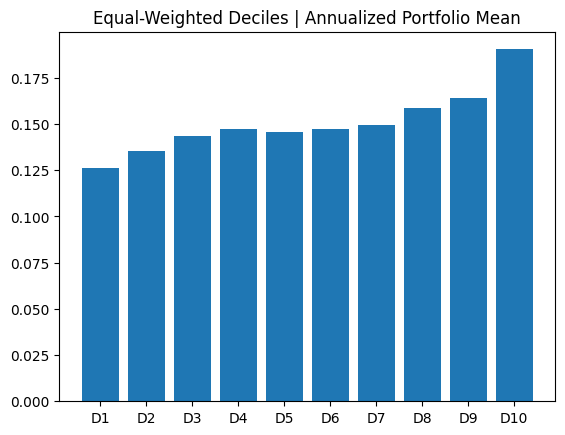

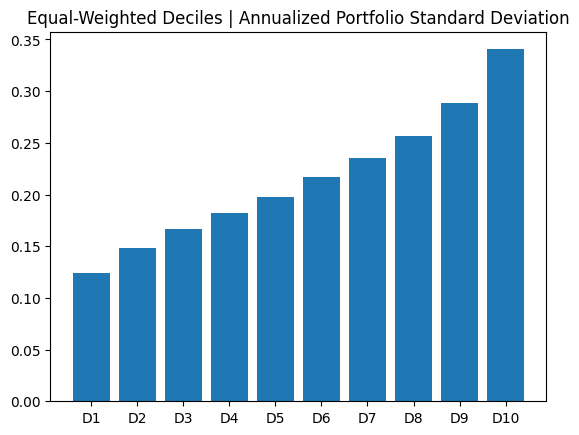

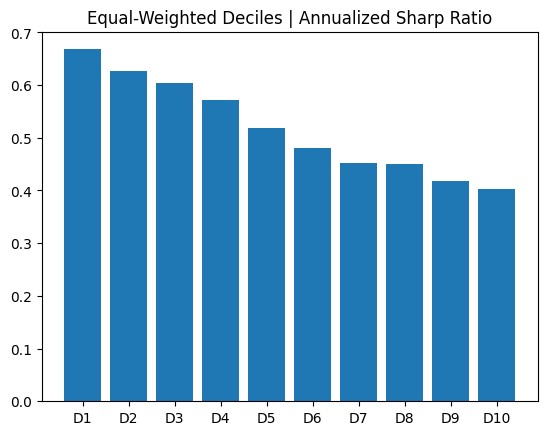

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Equal-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [33]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].mean()*12),plt.title('Equal-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].std()*np.sqrt(12)),plt.title('Equal-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_ew.groupby('idio_risk_decile')['ew_decile_excess_ret'].mean()*np.sqrt(12)/ret_ew.groupby('idio_risk_decile')['ew_decile_ret'].std()),plt.title('Equal-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

#### Value Weighted

In [34]:
data_iv = data_iv.dropna(subset='idio_risk').copy()
data_iv['idio_risk_decile'] = data_iv.groupby('date')['idio_risk'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# Compute weights for value-weighted portfolios
data_iv['vw_decile'] = data_iv['mcap_l'] / data_iv.groupby(['date','idio_risk_decile'])['mcap_l'].transform('sum')
# Compute returns for each portfolio
data_iv['vw_decile_ret'] = data_iv['vw_decile'] * data_iv['Rn']
data_iv['vw_decile_excess_ret'] = data_iv['vw_decile'] * data_iv['Rn_e']
ret_vw = data_iv.groupby(['date','idio_risk_decile'])['vw_decile_ret'].sum().reset_index()
vw_decile_excess_ret = data_iv.groupby(['date', 'idio_risk_decile'])['vw_decile_excess_ret'].sum().reset_index(name='vw_decile_excess_ret')
ret_vw = ret_vw.merge(vw_decile_excess_ret, on=['date', 'idio_risk_decile'])
ret_vw

,date,idio_risk_decile,vw_decile_ret,vw_decile_excess_ret
0,1967-02-28,0,0.007837,0.004100
1,1967-02-28,1,0.000118,-0.003619
2,1967-02-28,2,0.008759,0.005022
3,1967-02-28,3,0.025754,0.022017
4,1967-02-28,4,0.005843,0.002106
...,...,...,...,...
6638,2023-12-29,4,0.048551,0.044066
6639,2023-12-29,5,0.086762,0.082277
6640,2023-12-29,6,0.084141,0.079656
6641,2023-12-29,7,0.085963,0.081479


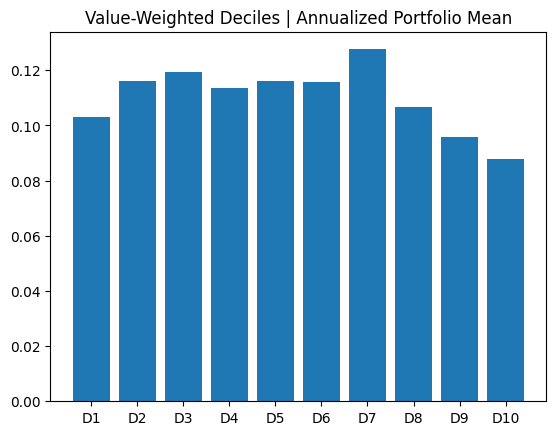

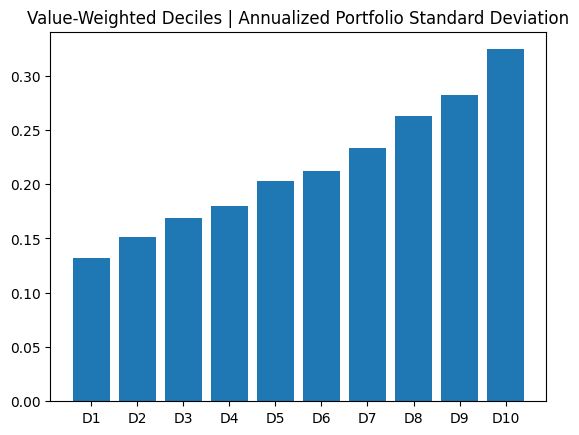

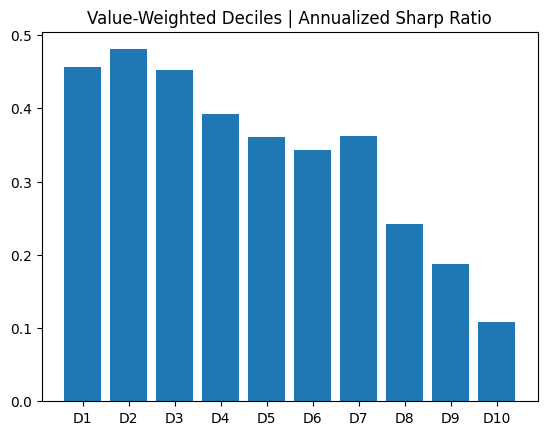

(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Value-Weighted Deciles | Annualized Sharp Ratio'),
 None)

In [35]:
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].mean()*12),plt.title('Value-Weighted Deciles | Annualized Portfolio Mean'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].std()*np.sqrt(12)),plt.title('Value-Weighted Deciles | Annualized Portfolio Standard Deviation'), plt.show()
plt.bar(['D'+ str(x) for x in np.arange(1,11)], ret_vw.groupby('idio_risk_decile')['vw_decile_excess_ret'].mean()*np.sqrt(12)/ret_vw.groupby('idio_risk_decile')['vw_decile_ret'].std()),plt.title('Value-Weighted Deciles | Annualized Sharp Ratio'), plt.show()

### Idiosyncratic Volatility Portfolio

In [36]:
long_iv = data_iv[data_iv['idio_risk_decile'].isin([7,8,9])].copy()
short_iv = data_iv[data_iv['idio_risk_decile'].isin([0,1,2])].copy()

#### Equally Weighted Portfolio

In [37]:
# long_iv portfolio: Equal-weighted average of the top three deciles (Deciles 7, 8 and 9)
ew_long_iv_rets = long_iv.groupby('date')['Rn'].mean() 
ew_long_iv_excess_rets = long_iv.groupby('date')['Rn_e'].mean() 
# short_iv portfolio: Equal-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
ew_short_iv_rets = short_iv.groupby('date')['Rn'].mean() 
ew_short_iv_excess_rets = short_iv.groupby('date')['Rn_e'].mean() 
# Compute the return of the iv strategy as the difference between the long_iv and short_iv portfolios' returns
ew_iv_rets = ew_long_iv_rets - ew_short_iv_rets

In [38]:
ew_long_iv_mean, ew_long_iv_std, ew_long_iv_sharpe = calculate_portfolio_metrics(ew_long_iv_rets, ew_long_iv_excess_rets)
ew_short_iv_mean, ew_short_iv_std, ew_short_iv_sharpe = calculate_portfolio_metrics(ew_short_iv_rets, ew_short_iv_excess_rets)
ew_iv_mean, ew_iv_std, ew_iv_sharpe = calculate_portfolio_metrics(ew_iv_rets, ew_long_iv_excess_rets - ew_short_iv_excess_rets)
ew_t_stat, ew_p_value = stats.ttest_1samp(ew_iv_rets, 0)

print(f"Equal-Weighted Portfolio Metrics:")
print(f"long_iv Portfolio: Mean = {ew_long_iv_mean:.3%}, Std Dev = {ew_long_iv_std:.3%}, Sharpe Ratio = {ew_long_iv_sharpe:.3f}")
print(f"short_iv Portfolio: Mean = {ew_short_iv_mean:.3%}, Std Dev = {ew_short_iv_std:.3%}, Sharpe Ratio = {ew_short_iv_sharpe:.3f}")
print(f"iv Strategy: Mean = {ew_iv_mean:.3%}, Std Dev = {ew_iv_std:.3%}, Sharpe Ratio = {ew_iv_sharpe:.3f}")
print(f"T-statistic = {ew_t_stat:.2f}, P-value = {ew_p_value:.4f}\n")

Equal-Weighted Portfolio Metrics:
long_iv Portfolio: Mean = 16.414%, Std Dev = 28.250%, Sharpe Ratio = 0.429
short_iv Portfolio: Mean = 13.500%, Std Dev = 14.219%, Sharpe Ratio = 0.647
iv Strategy: Mean = 2.914%, Std Dev = 19.439%, Sharpe Ratio = 0.150
T-statistic = 1.13, P-value = 0.2588



#### Value Weighted Portfolio

In [39]:
# long_iv portfolio: Value-weighted average of the top three deciles (Deciles 7, 8 and 9)
long_iv_weights = long_iv['mcap_l'] / long_iv.groupby('date')['mcap_l'].transform('sum')
long_iv['vw_rets'] = long_iv_weights * long_iv['Rn']
vw_long_iv_rets = long_iv.groupby('date')['vw_rets'].sum()
long_iv['vw_excess_rets'] = long_iv_weights * long_iv['Rn_e']
vw_long_iv_excess_rets = long_iv.groupby('date')['vw_excess_rets'].sum()
# short_iv portfolio: Value-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
short_iv_weights = short_iv['mcap_l'] / short_iv.groupby('date')['mcap_l'].transform('sum')
short_iv['vw_rets'] = short_iv_weights * short_iv['Rn']
vw_short_iv_rets = short_iv.groupby('date')['vw_rets'].sum()
short_iv['vw_excess_rets'] = short_iv_weights * short_iv['Rn_e']
vw_short_iv_excess_rets = short_iv.groupby('date')['vw_excess_rets'].sum()
# Compute the return of the iv strategy as the difference between the long_iv and short_iv portfolios' returns
vw_iv_rets = vw_long_iv_rets - vw_short_iv_rets

In [40]:
IV_returns = vw_iv_rets.copy()

In [41]:
vw_long_iv_mean, vw_long_iv_std, vw_long_iv_sharpe = calculate_portfolio_metrics(vw_long_iv_rets, vw_long_iv_excess_rets)
vw_short_iv_mean, vw_short_iv_std, vw_short_iv_sharpe = calculate_portfolio_metrics(vw_short_iv_rets, vw_short_iv_excess_rets)
vw_iv_mean, vw_iv_std, vw_iv_sharpe = calculate_portfolio_metrics(vw_iv_rets, vw_long_iv_excess_rets - vw_short_iv_excess_rets)
vw_t_stat, vw_p_value = stats.ttest_1samp(vw_iv_rets, 0)

print(f"Value-Weighted Portfolio Metrics:")
print(f"long_iv Portfolio: Mean = {vw_long_iv_mean:.3%}, Std Dev = {vw_long_iv_std:.3%}, Sharpe Ratio = {vw_long_iv_sharpe:.3f}")
print(f"short_iv Portfolio: Mean = {vw_short_iv_mean:.3%}, Std Dev = {vw_short_iv_std:.3%}, Sharpe Ratio = {vw_short_iv_sharpe:.3f}")
print(f"iv Strategy: Mean = {vw_iv_mean:.3%}, Std Dev = {vw_iv_std:.3%}, Sharpe Ratio = {vw_iv_sharpe:.3f}")
print(f"T-statistic = {vw_t_stat:.2f}, P-value = {vw_p_value:.4f}\n")

Value-Weighted Portfolio Metrics:
long_iv Portfolio: Mean = 9.440%, Std Dev = 26.439%, Sharpe Ratio = 0.194
short_iv Portfolio: Mean = 10.855%, Std Dev = 13.958%, Sharpe Ratio = 0.469
iv Strategy: Mean = -1.415%, Std Dev = 18.442%, Sharpe Ratio = -0.077
T-statistic = -0.58, P-value = 0.5630



## Optimal Fund Portfolio Return (STRAT)

In [110]:
IV_returns = pd.DataFrame(IV_returns)
MOM_returns = pd.DataFrame(MOM_returns)

In [111]:
IV_returns.rename(columns = {'vw_rets':'R_IV'}, inplace = True)
MOM_returns.rename(columns = {'vw_rets':'R_MOM'}, inplace = True)

In [112]:
returns = pd.merge(BAB_returns, IV_returns, on='date', how='inner')
returns = pd.merge(returns, MOM_returns, on='date', how='inner')
returns = pd.merge(returns, data_bab[['date','rf']].drop_duplicates(), on='date', how='inner')
returns

,date,R_BAB,R_IV,R_MOM,rf
0,1967-02-28,0.016480,0.015470,0.037559,0.003737
1,1967-03-31,0.006409,-0.000844,0.007034,0.003385
2,1967-04-28,0.020326,0.014831,-0.009939,0.002877
3,1967-05-31,0.003236,0.004448,0.019453,0.002707
4,1967-06-30,-0.010238,0.095494,0.048491,0.003089
...,...,...,...,...,...
677,2023-08-31,-0.012749,-0.014145,0.055875,0.004463
678,2023-09-29,-0.042913,0.015156,0.003078,0.004472
679,2023-10-31,0.003591,-0.032873,-0.022135,0.004475
680,2023-11-30,0.037604,-0.018691,0.025636,0.004455


#### Equally Weighted Portfolio

In [113]:
returns['EW_BAB_weight'] = 1/3
returns['EW_IV_weight'] = 1/3
returns['EW_MOM_weight'] = 1/3
returns['EW'] = returns['EW_BAB_weight'] * returns['R_BAB'] + returns['EW_IV_weight'] * returns['R_IV'] + returns['EW_MOM_weight'] * returns['R_MOM']

In [114]:
# TODO: check whether we should have (1- c) or 1
c = 0.1 / (returns['EW'].std() * np.sqrt(12))
returns['EW_BAB_weight'] = c * returns['EW_BAB_weight']
returns['EW_IV_weight'] = c * returns['EW_IV_weight']
returns['EW_MOM_weight'] = c * returns['EW_MOM_weight']
returns['EW'] = returns['EW_BAB_weight'] * returns['R_BAB'] + returns['EW_IV_weight'] * returns['R_IV'] + returns['EW_MOM_weight'] * returns['R_MOM'] + returns['rf']

In [115]:
# Define the rolling window size
window_size = 60

# Calculate the rolling standard deviation of each strategy's returns
returns['R_BAB_vol'] = returns['R_BAB'].rolling(window_size, min_periods=36, closed = 'left').std()
returns['R_IV_vol'] = returns['R_IV'].rolling(window_size, min_periods=36, closed = 'left').std()
returns['R_MOM_vol'] = returns['R_MOM'].rolling(window_size, min_periods=36, closed = 'left').std()

# Calculate the inverse volatilities
returns['R_BAB_inv_vol'] = 1 / returns['R_BAB_vol']
returns['R_IV_inv_vol'] = 1 / returns['R_IV_vol']
returns['R_MOM_inv_vol'] = 1 / returns['R_MOM_vol']

# Calculate the sum of the inverse volatilities
returns['inv_vol_sum'] = returns[['R_BAB_inv_vol', 'R_IV_inv_vol', 'R_MOM_inv_vol']].sum(axis=1)

# Calculate the risk parity weights
returns['RP_BAB_weight'] = returns['R_BAB_inv_vol'] / returns['inv_vol_sum']
returns['RP_IV_weight'] = returns['R_IV_inv_vol'] / returns['inv_vol_sum']
returns['RP_MOM_weight'] = returns['R_MOM_inv_vol'] / returns['inv_vol_sum']

# Drop the intermediate columns
returns.drop(columns=['R_BAB_vol', 'R_IV_vol', 'R_MOM_vol', 'R_BAB_inv_vol', 'R_IV_inv_vol', 'R_MOM_inv_vol', 'inv_vol_sum'], inplace=True)



In [116]:
# Calculate the optimal fund portfolio return
returns['RP'] = returns['RP_BAB_weight'] * returns['R_BAB'] + returns['RP_IV_weight'] * returns['R_IV'] + returns['RP_MOM_weight'] * returns['R_MOM']

In [117]:
# TODO
# returns['c_RP'] = returns['RP'].rolling(window_size, min_periods=36, closed = 'left').std()

In [118]:
c = 0.1 / (returns['RP'].std() * np.sqrt(12))
returns['RP_BAB_weight'] = c * returns['RP_BAB_weight']
returns['RP_IV_weight'] = c * returns['RP_IV_weight']
returns['RP_MOM_weight'] = c * returns['RP_MOM_weight']
returns['RP'] = returns['RP_BAB_weight'] * returns['R_BAB'] + returns['RP_IV_weight'] * returns['R_IV'] + returns['RP_MOM_weight'] * returns['R_MOM'] +  returns['rf']

In [119]:
import numpy as np

# Define the rolling window size
window_size = 60

# Calculate the rolling mean of each strategy's returns
returns['R_BAB_excess_mean'] = returns['R_BAB'].rolling(window_size, min_periods=36, closed = 'left').mean()
returns['R_IV_excess_mean'] = returns['R_IV'].rolling(window_size, min_periods=36, closed = 'left').mean()
returns['R_MOM_excess_mean'] = returns['R_MOM'].rolling(window_size, min_periods=36, closed = 'left').mean()

# Calculate the rolling covariance matrix of the strategy returns
returns_cov = returns[['R_BAB', 'R_IV', 'R_MOM']].rolling(window_size, min_periods = 36, closed = 'left').cov()

# For each date, calculate the MVE weights by multiplying the inverse of the covariance matrix with the mean returns
jitter = 1e-6  # Small constant

weights = returns_cov.groupby(level=0).apply(lambda x: np.linalg.inv(x.values + np.eye(x.values.shape[0]) * jitter) @ np.array([returns.loc[x.index[0][0], 'R_BAB_excess_mean'], returns.loc[x.index[0][0], 'R_IV_excess_mean'], returns.loc[x.index[0][0], 'R_MOM_excess_mean']]))

returns.drop(columns=['R_BAB_excess_mean', 'R_IV_excess_mean', 'R_MOM_excess_mean'], inplace=True)
# Normalize the weights so they sum to 1


In [120]:
weights = pd.DataFrame(weights.values.tolist(), index=weights.index, columns=['BAB_MVE_weights', 'IV_MVE_weights', 'MOM_MVE_weights'])

In [121]:
weights = weights.div(weights.sum(axis=1), axis=0)

In [122]:
weights.tail()

,BAB_MVE_weights,IV_MVE_weights,MOM_MVE_weights
677,0.218493,1.338079,-0.556571
678,1.372730,-0.878286,0.505556
679,1.645671,-0.976159,0.330487
680,-1.610655,2.561716,0.048938
681,-0.208943,0.928229,0.280714


In [123]:
# Add the calculated weights to the DataFrame
returns['MVE_BAB_weight'] = weights.iloc[:, 0]
returns['MVE_IV_weight'] = weights.iloc[:, 1]
returns['MVE_MOM_weight'] = weights.iloc[:, 2]

In [124]:
returns['MVE'] = returns['MVE_BAB_weight'] * returns['R_BAB'] + returns['MVE_IV_weight'] * returns['R_IV'] + returns['MVE_MOM_weight'] * returns['R_MOM']

In [125]:
c = 0.1 / (returns['MVE'].std() * np.sqrt(12))
returns['MVE_BAB_weight'] = c * returns['MVE_BAB_weight']
returns['MVE_IV_weight'] = c * returns['MVE_IV_weight']
returns['MVE_MOM_weight'] = c * returns['MVE_MOM_weight']
returns['MVE'] = returns['MVE_BAB_weight'] * returns['R_BAB'] + returns['MVE_IV_weight'] * returns['R_IV'] + returns['MVE_MOM_weight'] * returns['R_MOM'] + returns['rf']

In [126]:
returns

,date,R_BAB,R_IV,R_MOM,rf,EW_BAB_weight,EW_IV_weight,EW_MOM_weight,EW,RP_BAB_weight,RP_IV_weight,RP_MOM_weight,RP,MVE_BAB_weight,MVE_IV_weight,MVE_MOM_weight,MVE
0,1967-02-28,0.016480,0.015470,0.037559,0.003737,0.362156,0.362156,0.362156,0.028910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1967-03-31,0.006409,-0.000844,0.007034,0.003385,0.362156,0.362156,0.362156,0.007948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1967-04-28,0.020326,0.014831,-0.009939,0.002877,0.362156,0.362156,0.362156,0.012010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1967-05-31,0.003236,0.004448,0.019453,0.002707,0.362156,0.362156,0.362156,0.012535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1967-06-30,-0.010238,0.095494,0.048491,0.003089,0.362156,0.362156,0.362156,0.051526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,2023-08-31,-0.012749,-0.014145,0.055875,0.004463,0.362156,0.362156,0.362156,0.014959,0.484389,0.286496,0.339122,0.013184,0.024938,0.152726,-0.063526,-0.001564
678,2023-09-29,-0.042913,0.015156,0.003078,0.004472,0.362156,0.362156,0.362156,-0.004466,0.490462,0.284308,0.335237,-0.011235,0.156681,-0.100246,0.057703,-0.003594
679,2023-10-31,0.003591,-0.032873,-0.022135,0.004475,0.362156,0.362156,0.362156,-0.014145,0.487733,0.285798,0.336476,-0.010616,0.187834,-0.111417,0.037721,0.007977
680,2023-11-30,0.037604,-0.018691,0.025636,0.004455,0.362156,0.362156,0.362156,0.020589,0.489108,0.286235,0.334664,0.026077,-0.183838,0.292391,0.005586,-0.007780


In [127]:
EW_mean, EW_std, EW_sharpe = calculate_portfolio_metrics(returns['EW'], returns['EW'] - returns['rf'])
RP_mean, RP_std, RP_sharpe = calculate_portfolio_metrics(returns['RP'], returns['RP'] - returns['rf'])
MVE_mean, MVE_std, MVE_sharpe = calculate_portfolio_metrics(returns['MVE'], returns['MVE'] - returns['rf'])

print(f"Equally Weighted Portfolio Metrics:")
print(f"Mean = {EW_mean:.2%}, Std Dev = {EW_std:.2%}, Sharpe Ratio = {EW_sharpe:.2f}\n")
print(f"Risk Parity Portfolio Metrics:")
print(f"Mean = {RP_mean:.2%}, Std Dev = {RP_std:.2%}, Sharpe Ratio = {RP_sharpe:.2f}\n")
print(f"Mean-Variance Efficient Portfolio Metrics:")
print(f"Mean = {MVE_mean:.2%}, Std Dev = {MVE_std:.2%}, Sharpe Ratio = {MVE_sharpe:.2f}\n")

Equally Weighted Portfolio Metrics:
Mean = 9.78%, Std Dev = 10.03%, Sharpe Ratio = 0.55

Risk Parity Portfolio Metrics:
Mean = 10.64%, Std Dev = 10.03%, Sharpe Ratio = 0.64

Mean-Variance Efficient Portfolio Metrics:
Mean = 4.06%, Std Dev = 10.10%, Sharpe Ratio = -0.02



## Performance and risk analysis for the Fund strategy

### a)

In [128]:
new_returns = returns[['RP', 'date']]
new_returns['date'] = new_returns['date'].apply(lambda x: x.strftime('%Y-%m'))
new_returns['date'] = pd.to_datetime(new_returns['date'])
new_returns = new_returns.set_index('date')
# drop nan values
new_returns = new_returns.dropna()
new_returns.index

C:\Users\Amirmahdi\AppData\Local\Temp\ipykernel_13016\3728675472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_returns['date'] = new_returns['date'].apply(lambda x: x.strftime('%Y-%m'))
C:\Users\Amirmahdi\AppData\Local\Temp\ipykernel_13016\3728675472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_returns['date'] = pd.to_datetime(new_returns['date'])


DatetimeIndex(['1970-03-01', '1970-04-01', '1970-05-01', '1970-06-01',
               '1970-07-01', '1970-08-01', '1970-09-01', '1970-10-01',
               '1970-11-01', '1970-12-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='date', length=646, freq=None)

In [129]:
# TODO
# new_returns.index = new_returns.index + pd.DateOffset(months=1)

In [130]:
# read the Fama French factors
ff_factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, sep=',')
ff_factors = ff_factors.iloc[:729]
ff_factors = ff_factors.rename(columns={'Unnamed: 0': 'date'})
ff_factors['date'] = pd.to_datetime(ff_factors['date'], format='%Y%m')
ff_factors = ff_factors.set_index('date')
ff_factors = ff_factors.astype(float)
ff_factors = ff_factors / 100
ff_factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
1963-07-01,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1963-08-01,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
1963-09-01,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
1963-10-01,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
1963-11-01,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
...,...,...,...,...,...,...
2023-11-01,0.0884,-0.0012,0.0164,-0.0391,-0.0100,0.0044
2023-12-01,0.0487,0.0732,0.0493,-0.0307,0.0132,0.0043
2024-01-01,0.0070,-0.0574,-0.0238,0.0069,-0.0096,0.0047


In [131]:
# Read the industry_returns Portfolios data
# Import data
industry_returns = pd.read_csv("monthly_12_industries_portfolios.csv",sep=";")
industry_returns['Date'] = pd.to_datetime(industry_returns['Date'], format='%Y%m')  # First, ensure that "date" is in datetime format
industry_returns = industry_returns.set_index('Date')  # Then, set the index to be the date
industry_returns = industry_returns / 100  # Convert the data to decimal format
industry_returns

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
1926-07-01,0.0145,0.1555,0.0367,-0.0118,0.0801,0.0316,0.0083,0.0704,0.0011,0.0177,-0.0002,0.0222
1926-08-01,0.0397,0.0368,0.0242,0.0347,0.0514,0.0197,0.0217,-0.0169,-0.0071,0.0425,0.0447,0.0434
1926-09-01,0.0114,0.0480,-0.0007,-0.0339,0.0530,-0.0034,0.0241,0.0204,0.0021,0.0069,-0.0161,0.0037
1926-10-01,-0.0124,-0.0823,-0.0316,-0.0078,-0.0455,-0.0538,-0.0011,-0.0263,-0.0229,-0.0057,-0.0551,-0.0273
1926-11-01,0.0520,-0.0019,0.0382,0.0001,0.0511,0.0479,0.0163,0.0371,0.0643,0.0542,0.0234,0.0210
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,0.0353,0.0661,0.0783,0.0018,0.0285,0.0466,0.0226,0.0169,0.0590,0.0690,0.0677,0.0634
2024-01-01,-0.0177,-0.1791,-0.0194,-0.0011,0.0056,0.0311,0.0453,-0.0300,0.0128,0.0352,0.0072,0.0129
2024-02-01,0.0192,0.0721,0.0613,0.0295,0.0316,0.0611,-0.0272,0.0243,0.0946,0.0463,0.0364,0.0660


In [132]:
data = pd.merge(new_returns, ff_factors, left_index=True, right_index=True, how='inner')
data = pd.merge(data, industry_returns, left_index=True, right_index=True, how='inner')
data

,RP,Mkt-RF,SMB,HML,RMW,CMA,RF,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
1970-03-01,0.009745,-0.0106,-0.0241,0.0399,-0.0100,0.0429,0.0057,-0.0078,0.0487,-0.0027,-0.0045,-0.0038,-0.0259,0.0229,0.0291,-0.0169,-0.0508,-0.0077,-0.0291
1970-04-01,-0.034969,-0.1100,-0.0640,0.0618,-0.0064,0.0621,0.0050,-0.1012,-0.0886,-0.0978,-0.0917,-0.0624,-0.1445,-0.0879,-0.0805,-0.1108,-0.1011,-0.1278,-0.1451
1970-05-01,-0.038373,-0.0692,-0.0448,0.0333,-0.0121,0.0390,0.0053,-0.0745,-0.0645,-0.0901,0.0261,-0.0297,-0.0950,-0.0375,-0.0536,-0.0945,-0.0778,-0.0837,-0.0814
1970-06-01,0.025121,-0.0579,-0.0220,0.0060,0.0013,0.0296,0.0058,-0.0147,-0.0415,-0.0561,-0.0247,-0.0245,-0.1189,-0.0848,-0.0470,-0.0402,-0.0051,-0.0455,-0.0895
1970-07-01,0.000950,0.0693,-0.0062,0.0090,-0.0026,0.0184,0.0052,0.0668,0.1060,0.0451,0.1276,0.0677,0.0236,0.1026,0.0870,0.1038,0.0216,0.0886,0.0720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.013184,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,-0.0377,-0.0431,-0.0221,0.0195,-0.0275,-0.0167,0.0014,-0.0529,-0.0040,-0.0022,-0.0361,-0.0298
2023-09-01,-0.011235,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,-0.0457,-0.0258,-0.0730,0.0317,-0.0657,-0.0595,-0.0322,-0.0504,-0.0568,-0.0471,-0.0204,-0.0557
2023-10-01,-0.010616,-0.0319,-0.0405,0.0018,0.0247,-0.0065,0.0047,-0.0353,-0.1788,-0.0301,-0.0624,-0.0221,-0.0173,-0.0018,0.0112,0.0047,-0.0458,-0.0178,-0.0378
2023-11-01,0.026077,0.0884,-0.0012,0.0164,-0.0391,-0.0100,0.0044,0.0502,0.1576,0.0973,-0.0129,0.0628,0.1194,0.0697,0.0508,0.0718,0.0587,0.1025,0.1073


AttributeError: 'Summary' object has no attribute 'to_latex'

In [133]:
y = data['RP']
X = data.drop(columns='RP')
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RP   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     31.46
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           1.67e-75
Time:                        21:28:21   Log-Likelihood:                 1579.8
No. Observations:                 646   AIC:                            -3122.
Df Residuals:                     627   BIC:                            -3037.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.508      0.132      -0.001       0.005
Mkt-RF         1.2028      0.168      7.159      0.000       0.873       1.533
SMB            0.3051      0.036      8.431      0.000       0.234       0.376
HML            0.0456      0.054      0.845      0.398      -0.060       0.151
RMW            0.0298      0.053      0.564      0.573      -0.074       0.133
CMA            0.1386      0.066      2.086      0.037       0.008       0.269
RF             1.8939      0.343      5.515      0.000       1.220       2.568
NoDur         -0.0482      0.048     -0.996      0.320      -0.143       0.047
Durbl         -0.0806      0.020     -4.104      0.000      -0.119      -0.042
Manuf         -0.0166      0.054     -0.310      0.756      -0.122       0.089
Enrgy         -0.0749      0.023     -3.259      0.001      -0.120      -0.030
Chems         -0.1440      0.045     -3.220      0.001      -0.232      -0.056
BusEq         -0.1294      0.040     -3.265      0.001      -0.207      -0.052
Telcm         -0.1368      0.030     -4.631      0.000      -0.195      -0.079
Utils          0.1365      0.030      4.572      0.000       0.078       0.195
Shops         -0.0183      0.040     -0.455      0.649      -0.097       0.061
Hlth          -0.0327      0.032     -1.019      0.309      -0.096       0.030
Money         -0.2625      0.046     -5.723      0.000      -0.353      -0.172
Other         -0.0234      0.056     -0.421      0.674      -0.133       0.086
==============================================================================
Omnibus:                       28.992   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.631
Skew:                          -0.073   Prob(JB):                     1.88e-18
Kurtosis:                       4.735   Cond. No.                         425.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### b)

#### i)calculating stock weights in BAB

In [148]:
stock_data_bab = data_bab.copy()
aggregate_data_bab = BAB.copy()

In [149]:
aggregate_data_bab.rename(columns={'beta_H': 'beta_H_agg', 'beta_L': 'beta_L_agg'}, inplace=True)
aggregate_data_bab

,date,R_H_e,R_L_e,beta_H_agg,beta_L_agg,R_BAB
0,1967-02-28,0.042873,0.026483,2.022617,0.702911,0.016480
1,1967-03-31,0.073614,0.030251,2.037075,0.711013,0.006409
2,1967-04-28,0.046570,0.029867,2.029360,0.690177,0.020326
3,1967-05-31,-0.015518,-0.003046,2.014937,0.682246,0.003236
4,1967-06-30,0.126475,0.035032,1.974962,0.651128,-0.010238
...,...,...,...,...,...,...
677,2023-08-31,-0.063518,-0.031033,1.849712,0.659042,-0.012749
678,2023-09-29,-0.054433,-0.047927,1.854105,0.663147,-0.042913
679,2023-10-31,-0.078984,-0.026056,1.840931,0.662774,0.003591
680,2023-11-30,0.074733,0.051853,1.842138,0.663314,0.037604


In [150]:
aggregate_data_bab = aggregate_data_bab[['date', 'beta_H_agg', 'beta_L_agg']]

In [151]:
epsilon = 1e-8
# Merge data_bab and BAB on 'date'
BAB_weights = pd.merge(stock_data_bab, aggregate_data_bab, on='date', how='left')

# Create new column
BAB_weights['weight_in_BAB'] = - BAB_weights['w_H'] / BAB_weights['beta_H_agg'] + BAB_weights['w_L'] / BAB_weights['beta_L_agg']

BAB_weights

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,...,k,w_H,w_L,beta_H,beta_L,R_H_e,R_L_e,beta_H_agg,beta_L_agg,weight_in_BAB
0,10001,2013-02-28,11,2,4925,0.011651,8157.0,9.94,81080.58,80509.59,...,0.000005,-0.000000,0.002548,-0.000000,0.001151,-0.000000,0.000030,1.965942,0.625297,0.004074
1,10001,2013-03-28,11,2,4925,0.030684,8157.0,10.20,83201.40,81080.58,...,0.000005,-0.000000,0.002552,-0.000000,0.001152,-0.000000,0.000078,1.965592,0.626230,0.004076
2,10001,2013-04-30,11,2,4925,0.017157,8390.0,10.33,86668.70,83201.40,...,0.000005,-0.000000,0.002541,-0.000000,0.001159,-0.000000,0.000044,1.962491,0.627302,0.004051
3,10001,2013-05-31,11,2,4925,-0.000484,8390.0,10.28,86249.20,86668.70,...,0.000005,-0.000000,0.002543,-0.000000,0.001160,0.000000,-0.000001,1.963622,0.626132,0.004061
4,10001,2013-06-28,11,2,4925,0.006323,8647.0,10.30,89064.10,86249.20,...,0.000005,-0.000000,0.002550,-0.000000,0.001161,-0.000000,0.000016,1.965399,0.627433,0.004065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103448,93426,2023-08-31,11,1,3676,-0.037156,12581.0,36.02,453167.62,470505.57,...,0.000007,0.000520,-0.000000,0.000683,-0.000000,-0.000022,0.000000,1.849712,0.659042,-0.000281
1103449,93426,2023-09-29,11,1,3676,-0.067740,12581.0,33.58,422469.98,453167.62,...,0.000007,0.000509,-0.000000,0.000665,-0.000000,-0.000037,0.000000,1.854105,0.663147,-0.000274
1103450,93426,2023-10-31,11,1,3676,-0.108993,12581.0,29.92,376423.52,422469.98,...,0.000007,0.000490,-0.000000,0.000637,-0.000000,-0.000056,0.000000,1.840931,0.662774,-0.000266
1103451,93426,2023-11-30,11,1,3676,0.019051,12510.0,30.49,381429.90,376423.52,...,0.000007,0.000502,-0.000000,0.000652,-0.000000,0.000007,-0.000000,1.842138,0.663314,-0.000272


#### ii) calculating stock weights in MOM

In [159]:
long_portfolio = long_mom.copy()[['date', 'permno']]
long_weights = pd.DataFrame(long_mom_weights)
long_weights.rename(columns={'mcap_l':'weight_in_long_MOM'}, inplace=True)
long_portfolio = pd.concat([long_portfolio, long_weights], axis = 1)
long_portfolio

,date,permno,weight_in_long_MOM
24,2012-02-29,10001,0.000018
27,2012-05-31,10001,0.000021
55,2014-09-30,10001,0.000026
57,2014-11-28,10001,0.000019
58,2014-12-31,10001,0.000020
...,...,...,...
1315844,2023-04-28,93426,0.000110
1315845,2023-05-31,93426,0.000087
1315846,2023-06-30,93426,0.000071
1315847,2023-07-31,93426,0.000062


In [161]:
short_portfolio = short_mom.copy()[['date', 'permno']]
short_weights = pd.DataFrame(short_mom_weights)
short_weights.rename(columns={'mcap_l':'weight_in_short_MOM'}, inplace=True)
short_portfolio = pd.concat([short_portfolio, short_weights], axis = 1)
short_portfolio

,date,permno,weight_in_short_MOM
16,2011-06-30,10001,0.000044
17,2011-07-29,10001,0.000041
18,2011-08-31,10001,0.000038
32,2012-10-31,10001,0.000062
33,2012-11-30,10001,0.000064
...,...,...,...
1315816,2020-12-31,93426,0.000170
1315818,2021-02-26,93426,0.000125
1315821,2021-05-28,93426,0.000039
1315823,2021-07-30,93426,0.000047


In [162]:
data_mom['date'] = pd.to_datetime(data_mom['date'])
data_mom

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,...,N,index,lagged_11_month_ret,lagged_11_month_ret_decile,ew_lagged_decile,ew_lagged_decile_ret,ew_lagged_decile_excess_ret,vw_lagged_decile,vw_lagged_decile_ret,vw_lagged_decile_excess_ret
0,10001,2010-01-29,11,2,4925,-0.018932,4361.0,10.0600,43871.6600,44918.3000,...,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,2010-02-26,11,2,4925,-0.000656,4361.0,10.0084,43646.6324,43871.6600,...,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,2010-03-31,11,2,4925,0.020643,4361.0,10.1700,44351.3700,43646.6324,...,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,2010-04-30,11,2,4925,0.124385,6070.0,11.3900,69137.3000,44351.3700,...,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,2010-05-28,11,2,4925,0.004829,6071.0,11.4000,69209.4000,69137.3000,...,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315848,93426,2023-08-31,11,1,3676,-0.037156,12581.0,36.0200,453167.6200,470505.5700,...,160,1315848.0,0.175187,7.0,0.009009,-0.000335,-0.000375,0.000214,-0.000008,-0.000009
1315849,93426,2023-09-29,11,1,3676,-0.067740,12581.0,33.5800,422469.9800,453167.6200,...,160,1315849.0,0.086501,5.0,0.009091,-0.000616,-0.000656,0.000133,-0.000009,-0.000010
1315850,93426,2023-10-31,11,1,3676,-0.108993,12581.0,29.9200,376423.5200,422469.9800,...,160,1315850.0,0.196638,5.0,0.009174,-0.001000,-0.001041,0.000154,-0.000017,-0.000018
1315851,93426,2023-11-30,11,1,3676,0.019051,12510.0,30.4900,381429.9000,376423.5200,...,160,1315851.0,-0.005050,4.0,0.009174,0.000175,0.000134,0.000134,0.000003,0.000002


In [163]:
# Merge the dataframes
MOM_weights = pd.merge(data_mom, long_portfolio, on=['date', 'permno'], how='left')

# Replace NaN values with zero
MOM_weights['weight_in_long_MOM'] = MOM_weights['weight_in_long_MOM'].fillna(0)

MOM_weights = pd.merge(MOM_weights, short_portfolio, on=['date', 'permno'], how='left')

# Replace NaN values with zero
MOM_weights['weight_in_short_MOM'] = MOM_weights['weight_in_short_MOM'].fillna(0)
MOM_weights

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,...,lagged_11_month_ret,lagged_11_month_ret_decile,ew_lagged_decile,ew_lagged_decile_ret,ew_lagged_decile_excess_ret,vw_lagged_decile,vw_lagged_decile_ret,vw_lagged_decile_excess_ret,weight_in_long_MOM,weight_in_short_MOM
0,10001,2010-01-29,11,2,4925,-0.018932,4361.0,10.0600,43871.6600,44918.3000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,10001,2010-02-26,11,2,4925,-0.000656,4361.0,10.0084,43646.6324,43871.6600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2,10001,2010-03-31,11,2,4925,0.020643,4361.0,10.1700,44351.3700,43646.6324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
3,10001,2010-04-30,11,2,4925,0.124385,6070.0,11.3900,69137.3000,44351.3700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
4,10001,2010-05-28,11,2,4925,0.004829,6071.0,11.4000,69209.4000,69137.3000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315848,93426,2023-08-31,11,1,3676,-0.037156,12581.0,36.0200,453167.6200,470505.5700,...,0.175187,7.0,0.009009,-0.000335,-0.000375,0.000214,-0.000008,-0.000009,0.000076,0.000000
1315849,93426,2023-09-29,11,1,3676,-0.067740,12581.0,33.5800,422469.9800,453167.6200,...,0.086501,5.0,0.009091,-0.000616,-0.000656,0.000133,-0.000009,-0.000010,0.000000,0.000000
1315850,93426,2023-10-31,11,1,3676,-0.108993,12581.0,29.9200,376423.5200,422469.9800,...,0.196638,5.0,0.009174,-0.001000,-0.001041,0.000154,-0.000017,-0.000018,0.000000,0.000000
1315851,93426,2023-11-30,11,1,3676,0.019051,12510.0,30.4900,381429.9000,376423.5200,...,-0.005050,4.0,0.009174,0.000175,0.000134,0.000134,0.000003,0.000002,0.000000,0.000000


In [164]:
MOM_weights['weight_in_MOM'] = MOM_weights['weight_in_long_MOM'] - MOM_weights['weight_in_short_MOM']

#### iii) calculating stock weights in IV

In [165]:
long_portfolio = long_iv.copy()[['date', 'permno']]
long_weights = pd.DataFrame(long_iv_weights)
long_weights.rename(columns={'mcap_l':'weight_in_long_IV'}, inplace=True)
long_portfolio = pd.concat([long_portfolio, long_weights], axis = 1)
long_portfolio

,date,permno,weight_in_long_IV
382,1968-05-31,10014,0.001375
383,1968-06-28,10014,0.001520
384,1968-08-30,10014,0.001371
385,1968-09-30,10014,0.001550
386,1968-10-31,10014,0.001354
...,...,...,...
1315529,2020-10-30,93422,0.000410
1315530,2020-11-30,93422,0.000389
1315531,2020-12-31,93422,0.000549
1315532,2021-01-29,93422,0.000768


In [166]:
short_portfolio = short_iv.copy()[['date', 'permno']]
short_weights = pd.DataFrame(short_iv_weights)
short_weights.rename(columns={'mcap_l':'weight_in_short_IV'}, inplace=True)
short_portfolio = pd.concat([short_portfolio, short_weights], axis = 1)
short_portfolio

,date,permno,weight_in_short_IV
36,2013-02-28,10001,0.000010
37,2013-03-28,10001,0.000010
38,2013-04-30,10001,0.000010
39,2013-05-31,10001,0.000010
40,2013-06-28,10001,0.000010
...,...,...,...
1315848,2023-08-31,93426,0.000033
1315849,2023-09-29,93426,0.000033
1315850,2023-10-31,93426,0.000032
1315851,2023-11-30,93426,0.000030


In [167]:
data_iv['date'] = pd.to_datetime(data_iv['date'])
data_iv

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,...,Rm_e,N,idio_risk,idio_risk_decile,ew_decile,ew_decile_ret,ew_decile_excess_ret,vw_decile,vw_decile_ret,vw_decile_excess_ret
36,10001,2013-02-28,11,2,4925,0.011651,8157.0,9.94,81080.58,80509.59,...,0.008242,91,0.045867,0,0.007634,0.000089,0.000089,0.000019,2.160079e-07,2.152639e-07
37,10001,2013-03-28,11,2,4925,0.030684,8157.0,10.20,83201.40,81080.58,...,0.035261,91,0.045244,0,0.007634,0.000234,0.000234,0.000018,5.652420e-07,5.646195e-07
38,10001,2013-04-30,11,2,4925,0.017157,8390.0,10.33,86668.70,83201.40,...,0.014926,91,0.044749,0,0.007634,0.000131,0.000131,0.000018,3.119954e-07,3.117650e-07
39,10001,2013-05-31,11,2,4925,-0.000484,8390.0,10.28,86249.20,86668.70,...,0.019115,91,0.044749,0,0.007692,-0.000004,-0.000004,0.000019,-9.109020e-09,-9.347542e-09
40,10001,2013-06-28,11,2,4925,0.006323,8647.0,10.30,89064.10,86249.20,...,-0.015080,91,0.044749,0,0.007692,0.000049,0.000049,0.000019,1.186919e-07,1.185333e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315848,93426,2023-08-31,11,1,3676,-0.037156,12581.0,36.02,453167.62,470505.57,...,-0.025068,160,0.062502,2,0.009009,-0.000335,-0.000375,0.000198,-7.375382e-06,-8.261367e-06
1315849,93426,2023-09-29,11,1,3676,-0.067740,12581.0,33.58,422469.98,453167.62,...,-0.051862,160,0.062086,2,0.009091,-0.000616,-0.000656,0.000194,-1.313176e-05,-1.399860e-05
1315850,93426,2023-10-31,11,1,3676,-0.108993,12581.0,29.92,376423.52,422469.98,...,-0.033342,160,0.059817,1,0.009091,-0.000991,-0.001032,0.000104,-1.130094e-05,-1.176495e-05
1315851,93426,2023-11-30,11,1,3676,0.019051,12510.0,30.49,381429.90,376423.52,...,0.087602,160,0.060258,1,0.009174,0.000175,0.000134,0.000095,1.802268e-06,1.380819e-06


In [168]:
# Merge the dataframes
IV_weights = pd.merge(data_iv, long_portfolio, on=['date', 'permno'], how='left')

# Replace NaN values with zero
IV_weights['weight_in_long_IV'] = IV_weights['weight_in_long_IV'].fillna(0)

IV_weights = pd.merge(IV_weights, short_portfolio, on=['date', 'permno'], how='left')

# Replace NaN values with zero
IV_weights['weight_in_short_IV'] = IV_weights['weight_in_short_IV'].fillna(0)
IV_weights

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,...,idio_risk,idio_risk_decile,ew_decile,ew_decile_ret,ew_decile_excess_ret,vw_decile,vw_decile_ret,vw_decile_excess_ret,weight_in_long_IV,weight_in_short_IV
0,10001,2013-02-28,11,2,4925,0.011651,8157.0,9.94,81080.58,80509.59,...,0.045867,0,0.007634,0.000089,0.000089,0.000019,2.160079e-07,2.152639e-07,0.0,0.000010
1,10001,2013-03-28,11,2,4925,0.030684,8157.0,10.20,83201.40,81080.58,...,0.045244,0,0.007634,0.000234,0.000234,0.000018,5.652420e-07,5.646195e-07,0.0,0.000010
2,10001,2013-04-30,11,2,4925,0.017157,8390.0,10.33,86668.70,83201.40,...,0.044749,0,0.007634,0.000131,0.000131,0.000018,3.119954e-07,3.117650e-07,0.0,0.000010
3,10001,2013-05-31,11,2,4925,-0.000484,8390.0,10.28,86249.20,86668.70,...,0.044749,0,0.007692,-0.000004,-0.000004,0.000019,-9.109020e-09,-9.347542e-09,0.0,0.000010
4,10001,2013-06-28,11,2,4925,0.006323,8647.0,10.30,89064.10,86249.20,...,0.044749,0,0.007692,0.000049,0.000049,0.000019,1.186919e-07,1.185333e-07,0.0,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103448,93426,2023-08-31,11,1,3676,-0.037156,12581.0,36.02,453167.62,470505.57,...,0.062502,2,0.009009,-0.000335,-0.000375,0.000198,-7.375382e-06,-8.261367e-06,0.0,0.000033
1103449,93426,2023-09-29,11,1,3676,-0.067740,12581.0,33.58,422469.98,453167.62,...,0.062086,2,0.009091,-0.000616,-0.000656,0.000194,-1.313176e-05,-1.399860e-05,0.0,0.000033
1103450,93426,2023-10-31,11,1,3676,-0.108993,12581.0,29.92,376423.52,422469.98,...,0.059817,1,0.009091,-0.000991,-0.001032,0.000104,-1.130094e-05,-1.176495e-05,0.0,0.000032
1103451,93426,2023-11-30,11,1,3676,0.019051,12510.0,30.49,381429.90,376423.52,...,0.060258,1,0.009174,0.000175,0.000134,0.000095,1.802268e-06,1.380819e-06,0.0,0.000030


In [169]:
IV_weights['weight_in_IV'] = IV_weights['weight_in_long_IV'] - IV_weights['weight_in_short_IV']


In [170]:
# Merge the dataframes on 'date'
BAB_weights = pd.merge(BAB_weights, returns[['date', 'RP_BAB_weight']], on='date', how='left')

BAB_weights['weight_in_BAB_final'] = BAB_weights['weight_in_BAB'] * BAB_weights['RP_BAB_weight']

In [171]:
MOM_weights = pd.merge(MOM_weights, returns[['date', 'RP_MOM_weight']], on='date', how='left')

MOM_weights['weight_in_MOM_final'] = MOM_weights['weight_in_MOM'] * MOM_weights['RP_MOM_weight']

# MOM_weights.iloc[300:310]

In [172]:
IV_weights = pd.merge(IV_weights, returns[['date', 'RP_IV_weight']], on='date', how='left')

IV_weights['weight_in_IV_final'] = IV_weights['weight_in_IV'] * IV_weights['RP_IV_weight']

# IV_weights.iloc[300:310]

In [211]:
final_data = BAB_weights[['date', 'permno', 'weight_in_BAB_final', 'beta', 'siccd', 'rf']]
final_data = pd.merge(final_data, MOM_weights[['date', 'permno', 'weight_in_MOM_final']], on=['date', 'permno'], how='left')
final_data = pd.merge(final_data, IV_weights[['date', 'permno', 'weight_in_IV_final']], on=['date', 'permno'], how='left')
final_data

,date,permno,weight_in_BAB_final,beta,siccd,rf,weight_in_MOM_final,weight_in_IV_final
0,2013-02-28,10001,0.002090,0.451807,4925,0.000040,-0.000017,-0.000003
1,2013-03-28,10001,0.002076,0.451388,4925,0.000034,-0.000016,-0.000003
2,2013-04-30,10001,0.002044,0.455875,4925,0.000013,-0.000014,-0.000003
3,2013-05-31,10001,0.002050,0.456165,4925,0.000013,-0.000016,-0.000003
4,2013-06-28,10001,0.002049,0.455312,4925,0.000008,-0.000015,-0.000003
...,...,...,...,...,...,...,...,...
1103448,2023-08-31,93426,-0.000136,1.312988,3676,0.004463,0.000026,-0.000009
1103449,2023-09-29,93426,-0.000135,1.306562,3676,0.004472,0.000000,-0.000009
1103450,2023-10-31,93426,-0.000130,1.299385,3676,0.004475,0.000000,-0.000009
1103451,2023-11-30,93426,-0.000133,1.300548,3676,0.004455,0.000000,-0.000008


In [212]:
final_data['sum_of_weights'] = final_data['weight_in_BAB_final'] + final_data['weight_in_MOM_final'] + final_data['weight_in_IV_final']

In [213]:
final_data['beta_in_market'] = final_data['beta'] * final_data['sum_of_weights']

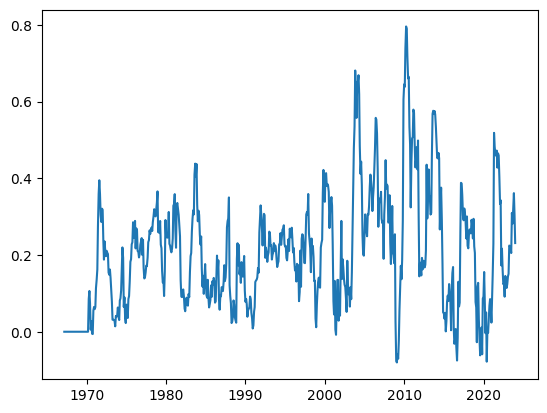

In [214]:
# compute the exposure to the market
strat_daily_beta = final_data.groupby('date')['beta_in_market'].sum()
plt.plot(strat_daily_beta)

In [215]:
# Here we calculate the weights in each industry

In [216]:
sic_map = pd.read_csv("SIC_to_Fama_French_industry.csv")
sic_map = sic_map[['SIC', 'FF_12']]

In [217]:
final_data = final_data.merge(sic_map, how='inner', left_on='siccd', right_on='SIC')
final_data

,date,permno,weight_in_BAB_final,beta,siccd,rf,weight_in_MOM_final,weight_in_IV_final,sum_of_weights,beta_in_market,SIC,FF_12
0,2013-02-28,10001,0.002090,0.451807,4925,0.000040,-0.000017,-0.000003,0.002071,0.000935,4925,8
1,2013-03-28,10001,0.002076,0.451388,4925,0.000034,-0.000016,-0.000003,0.002057,0.000928,4925,8
2,2013-04-30,10001,0.002044,0.455875,4925,0.000013,-0.000014,-0.000003,0.002027,0.000924,4925,8
3,2013-05-31,10001,0.002050,0.456165,4925,0.000013,-0.000016,-0.000003,0.002030,0.000926,4925,8
4,2013-06-28,10001,0.002049,0.455312,4925,0.000008,-0.000015,-0.000003,0.002030,0.000925,4925,8
...,...,...,...,...,...,...,...,...,...,...,...,...
1102602,2023-08-31,93426,-0.000136,1.312988,3676,0.004463,0.000026,-0.000009,-0.000120,-0.000158,3676,6
1102603,2023-09-29,93426,-0.000135,1.306562,3676,0.004472,0.000000,-0.000009,-0.000144,-0.000188,3676,6
1102604,2023-10-31,93426,-0.000130,1.299385,3676,0.004475,0.000000,-0.000009,-0.000139,-0.000181,3676,6
1102605,2023-11-30,93426,-0.000133,1.300548,3676,0.004455,0.000000,-0.000008,-0.000142,-0.000184,3676,6


In [218]:
# compute the exposure to each industry
industry_weights = final_data.groupby(['date', 'FF_12'])['sum_of_weights'].sum().unstack()
industry_weights

FF_12,1,2,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,
1967-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-04-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.042693,0.005900,0.069804,0.089896,0.016252,0.031630,-0.025241,0.078880,0.078209,0.068168,-0.006599,0.021732
2023-09-29,0.040682,0.003903,0.063611,0.086255,0.007012,0.061324,-0.031872,0.046677,0.036612,0.064321,0.068363,0.025326
2023-10-31,0.029949,0.000638,0.072847,0.111998,0.012409,0.091554,-0.012690,0.052967,0.041494,0.052583,-0.045702,0.059978


In [219]:
industry_weights.sum(axis = 0)

FF_12
1     40.419428
2      1.746117
3     36.048156
4     14.802630
5      5.588322
6     27.319891
7     -0.864644
8     84.759276
9     36.684942
10    14.821266
11    47.847309
12    44.563605
dtype: float64

In [220]:
Industries =['NoDur',
 'Durbl',
 'Manuf',
 'Enrgy',
 'Chems',
 'BusEq',
 'Telcm',
 'Utils',
 'Shops',
 'Hlth',
 'Money',
 'Other']

In [221]:
industry_weights.columns

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='FF_12')

In [222]:
industry_weights

FF_12,1,2,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,
1967-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-04-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1967-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.042693,0.005900,0.069804,0.089896,0.016252,0.031630,-0.025241,0.078880,0.078209,0.068168,-0.006599,0.021732
2023-09-29,0.040682,0.003903,0.063611,0.086255,0.007012,0.061324,-0.031872,0.046677,0.036612,0.064321,0.068363,0.025326
2023-10-31,0.029949,0.000638,0.072847,0.111998,0.012409,0.091554,-0.012690,0.052967,0.041494,0.052583,-0.045702,0.059978


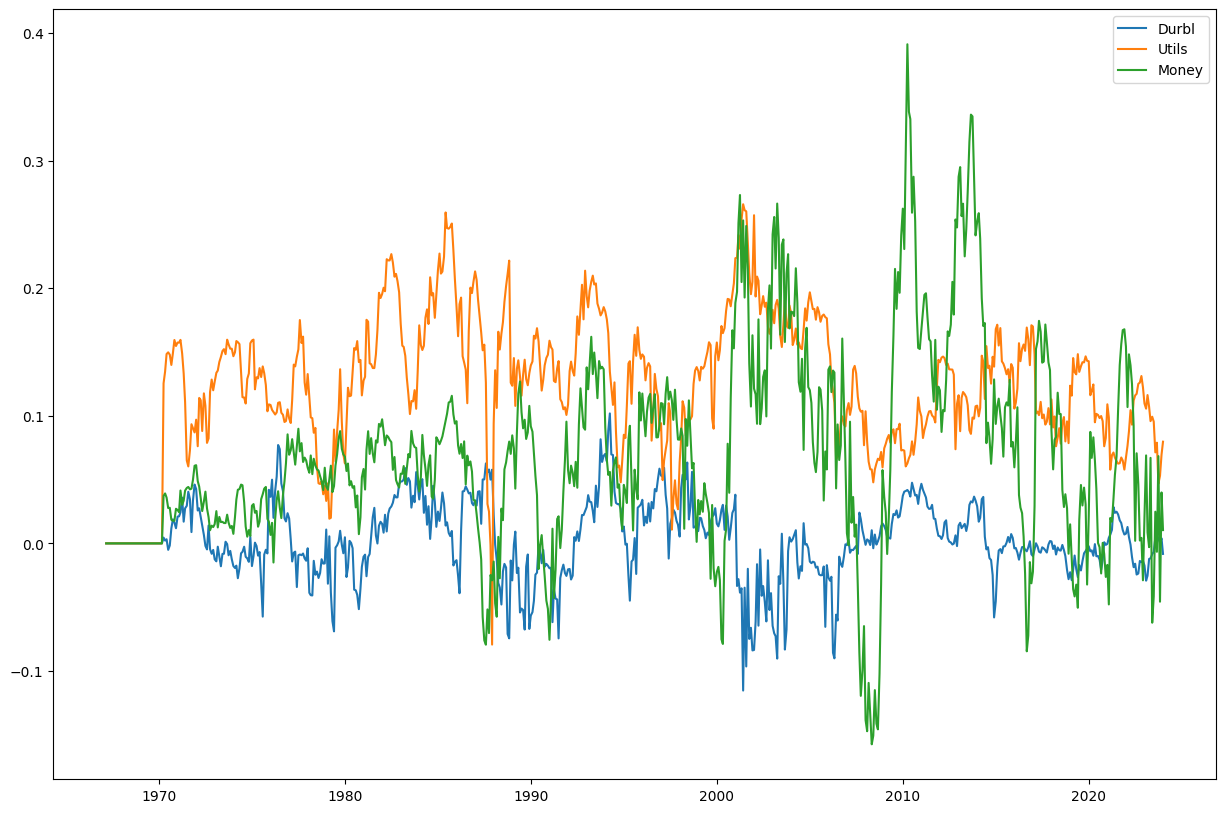

In [223]:
plt.figure(figsize=(15, 10))
plt.plot(industry_weights[2], label = Industries[1])
plt.plot(industry_weights[8], label = Industries[7])
plt.plot(industry_weights[11], label = Industries[10])
plt.legend()

In [224]:
industry_weights['date'] = industry_weights.index
industry_weights['date'] = industry_weights['date'].apply(lambda x: x.strftime('%Y-%m'))
industry_weights['date'] = pd.to_datetime(industry_weights['date'])
industry_weights = industry_weights.set_index('date')
industry_weights.index

DatetimeIndex(['1967-02-01', '1967-03-01', '1967-04-01', '1967-05-01',
               '1967-06-01', '1967-07-01', '1967-08-01', '1967-09-01',
               '1967-10-01', '1967-11-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='date', length=682, freq=None)

In [229]:
industry_combined = industry_weights.merge(industry_returns, left_index=True, right_index=True, how='inner')
industry_combined

,1,2,3,4,5,6,7,8,9,10,...,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
1967-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0156,-0.0007,0.0020,0.0625,0.0213,-0.0172,0.0325,0.0140,0.0022,-0.0058
1967-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0603,0.0361,0.0526,0.0537,0.0297,0.0153,0.0234,0.0786,0.0126,0.0589
1967-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0331,0.0167,0.0530,0.0779,0.0019,0.0188,0.0924,0.0446,0.0041,0.0293
1967-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.0337,-0.0242,-0.0464,-0.0435,-0.0567,-0.0411,-0.0463,-0.0528,-0.0242,-0.0192
1967-06-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0266,0.0227,0.0059,0.0635,0.0273,-0.0131,0.0384,0.0541,0.0375,0.0337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.042693,0.005900,0.069804,0.089896,0.016252,0.031630,-0.025241,0.078880,0.078209,0.068168,...,-0.0221,0.0195,-0.0275,-0.0167,0.0014,-0.0529,-0.0040,-0.0022,-0.0361,-0.0298
2023-09-01,0.040682,0.003903,0.063611,0.086255,0.007012,0.061324,-0.031872,0.046677,0.036612,0.064321,...,-0.0730,0.0317,-0.0657,-0.0595,-0.0322,-0.0504,-0.0568,-0.0471,-0.0204,-0.0557
2023-10-01,0.029949,0.000638,0.072847,0.111998,0.012409,0.091554,-0.012690,0.052967,0.041494,0.052583,...,-0.0301,-0.0624,-0.0221,-0.0173,-0.0018,0.0112,0.0047,-0.0458,-0.0178,-0.0378
2023-11-01,0.021006,0.003965,0.036873,0.114042,0.013948,0.075468,-0.016668,0.069488,0.031365,0.043238,...,0.0973,-0.0129,0.0628,0.1194,0.0697,0.0508,0.0718,0.0587,0.1025,0.1073


In [230]:
industry_combined

,1,2,3,4,5,6,7,8,9,10,...,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
1967-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0156,-0.0007,0.0020,0.0625,0.0213,-0.0172,0.0325,0.0140,0.0022,-0.0058
1967-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0603,0.0361,0.0526,0.0537,0.0297,0.0153,0.0234,0.0786,0.0126,0.0589
1967-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0331,0.0167,0.0530,0.0779,0.0019,0.0188,0.0924,0.0446,0.0041,0.0293
1967-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.0337,-0.0242,-0.0464,-0.0435,-0.0567,-0.0411,-0.0463,-0.0528,-0.0242,-0.0192
1967-06-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0266,0.0227,0.0059,0.0635,0.0273,-0.0131,0.0384,0.0541,0.0375,0.0337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.042693,0.005900,0.069804,0.089896,0.016252,0.031630,-0.025241,0.078880,0.078209,0.068168,...,-0.0221,0.0195,-0.0275,-0.0167,0.0014,-0.0529,-0.0040,-0.0022,-0.0361,-0.0298
2023-09-01,0.040682,0.003903,0.063611,0.086255,0.007012,0.061324,-0.031872,0.046677,0.036612,0.064321,...,-0.0730,0.0317,-0.0657,-0.0595,-0.0322,-0.0504,-0.0568,-0.0471,-0.0204,-0.0557
2023-10-01,0.029949,0.000638,0.072847,0.111998,0.012409,0.091554,-0.012690,0.052967,0.041494,0.052583,...,-0.0301,-0.0624,-0.0221,-0.0173,-0.0018,0.0112,0.0047,-0.0458,-0.0178,-0.0378
2023-11-01,0.021006,0.003965,0.036873,0.114042,0.013948,0.075468,-0.016668,0.069488,0.031365,0.043238,...,0.0973,-0.0129,0.0628,0.1194,0.0697,0.0508,0.0718,0.0587,0.1025,0.1073


In [226]:
industry_combined = industry_combined.merge(final_data[['rf']], left_index=True, right_index=True, how='inner')
industry_combined

,1,2,3,4,5,6,7,8,9,10,...,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,rf


In [ ]:
industry_combined

In [234]:
industry_combined['hedge_return'] = 0
for i in range(12):
    industry_combined['hedge_return'] -= industry_combined.iloc[:,i] * industry_combined.iloc[:,i+12]
industry_combined

,1,2,3,4,5,6,7,8,9,10,...,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,hedge_return
1967-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0358,0.1042,0.1015,0.0624,0.0284,0.1178,0.0645,0.0903,0.1342,0.000000
1967-02-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.0007,0.0020,0.0625,0.0213,-0.0172,0.0325,0.0140,0.0022,-0.0058,0.000000
1967-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0361,0.0526,0.0537,0.0297,0.0153,0.0234,0.0786,0.0126,0.0589,0.000000
1967-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0167,0.0530,0.0779,0.0019,0.0188,0.0924,0.0446,0.0041,0.0293,0.000000
1967-05-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.0242,-0.0464,-0.0435,-0.0567,-0.0411,-0.0463,-0.0528,-0.0242,-0.0192,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.050423,0.004386,0.074913,0.057748,0.018773,0.031860,-0.028405,0.080945,0.081902,0.083859,...,0.0195,-0.0275,-0.0167,0.0014,-0.0529,-0.0040,-0.0022,-0.0361,-0.0298,0.009994
2023-09-01,0.048816,0.002768,0.069330,0.052294,0.008531,0.062655,-0.035623,0.052204,0.036850,0.075728,...,0.0317,-0.0657,-0.0595,-0.0322,-0.0504,-0.0568,-0.0471,-0.0204,-0.0557,0.020838
2023-10-01,0.037715,-0.000317,0.077766,0.076970,0.014603,0.098857,-0.016031,0.056699,0.042890,0.068350,...,-0.0624,-0.0221,-0.0173,-0.0018,0.0112,0.0047,-0.0458,-0.0178,-0.0378,0.014771
2023-11-01,0.029833,0.003076,0.045956,0.064987,0.018087,0.082940,-0.018670,0.075167,0.037252,0.056679,...,-0.0129,0.0628,0.1194,0.0697,0.0508,0.0718,0.0587,0.1025,0.1073,-0.035980


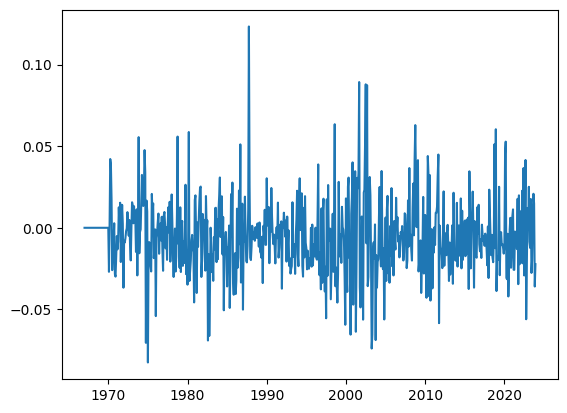

In [239]:
plt.plot(industry_combined['hedge_return'])

In [240]:
returns_copy = returns.copy()

In [ ]:
# TODO: check the dates for shifting or not
returns_copy['date'] = returns_copy['date'].apply(lambda x: x.strftime('%Y-%m'))
returns_copy['date'] = pd.to_datetime(returns_copy['date'])

In [ ]:
returns_copy.set_index('date', inplace=True)
returns_copy = returns_copy.merge(industry_combined['hedge_return'], left_index=True, right_index=True, how='inner')
returns_copy['return_after_hedge'] = returns_copy['RP'] + returns_copy['hedge_return']
returns_copy

,R_BAB,R_IV,R_MOM,rf,EW_BAB_weight,EW_IV_weight,EW_MOM_weight,EW,RP_BAB_weight,RP_IV_weight,RP_MOM_weight,RP,MVE_BAB_weight,MVE_IV_weight,MVE_MOM_weight,MVE,hedge_return,return_after_hedge
date,,,,,,,,,,,,,,,,,,
1967-01-01,0.070885,0.159371,0.159371,0.003788,0.747359,0.747359,0.747359,0.286487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1967-02-01,0.017369,0.035770,0.035770,0.003737,0.747359,0.747359,0.747359,0.061805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1967-03-01,0.005893,0.014321,0.014321,0.003385,0.747359,0.747359,0.747359,0.021606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1967-04-01,0.019804,0.028545,0.028545,0.002877,0.747359,0.747359,0.747359,0.053893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
1967-05-01,0.003044,0.024710,0.024710,0.002707,0.747359,0.747359,0.747359,0.035846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,-0.012752,-0.003425,-0.003425,0.004463,0.747359,0.747359,0.747359,-0.020194,1.446744,0.541845,0.541845,-0.028992,3.740464,-1.372340,-1.372340,-0.038281,0.031202,0.002210
2023-09-01,-0.042908,0.022047,0.022047,0.004472,0.747359,0.747359,0.747359,-0.004667,1.440037,0.545199,0.545199,-0.044592,3.107807,-1.056012,-1.056012,-0.179894,0.059133,0.014541
2023-10-01,0.003602,-0.024331,-0.024331,0.004475,0.747359,0.747359,0.747359,-0.039235,1.443789,0.543323,0.543323,-0.028087,5.334328,-2.169273,-2.169273,0.124796,0.033902,0.005815


In [ ]:
calculate_portfolio_metrics(returns_copy['return_after_hedge'], returns_copy['return_after_hedge'] - returns_copy['rf'])
print(f"Mean = {returns_copy['return_after_hedge'].mean():.2%}, Std Dev = {returns_copy['return_after_hedge'].std():.2%}, Sharpe Ratio = {returns_copy['return_after_hedge'].mean() / returns_copy['return_after_hedge'].std():.2f}\n")

Mean = 0.97%, Std Dev = 7.57%, Sharpe Ratio = 0.13



## Industry neutral strategy

In [56]:
data = pd.read_csv('data_with_siccd.csv', sep=',')
data['date'] = pd.to_datetime(data['date'])
data=data.sort_values(['date','permno']).reset_index(drop=True)
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()
data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N']>60].copy() # consider only those that have more than 5-years of data
data.drop(columns=['Unnamed: 0'], inplace=True)
data

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N
0,10006,1964-01-31,10,1,3743,0.068548,2948.0,66.250,195305.000,202675.000,0.002873,0.025790,1,0.065675,0.022917,243
1,10014,1964-01-31,10,1,3714,0.000000,3369.0,2.875,9685.875,9685.875,0.002873,0.025790,1,-0.002873,0.022917,157
3,10057,1964-01-31,11,1,3541,0.069915,500.0,62.500,31250.000,33000.000,0.002873,0.025790,1,0.067042,0.022917,388
4,10102,1964-01-31,10,1,2813,0.029083,5032.0,57.500,289340.000,278018.000,0.002873,0.025790,1,0.026210,0.022917,170
5,10137,1964-01-31,11,1,4911,-0.007371,9338.0,50.500,471569.000,490245.000,0.002873,0.025790,1,-0.010244,0.022917,563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439403,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.120,720652.900,0.004484,0.053468,1,0.092698,0.048984,162
1439404,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.020,37635.700,0.004484,0.053468,1,-0.030095,0.048984,162
1439405,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.640,2896005.370,0.004484,0.053468,1,0.085617,0.048984,161
1439406,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.960,2537102.050,0.004484,0.053468,1,0.002745,0.048984,161


In [57]:
industry_mapping = {
    'NoDur': [(100, 999), (2000, 2399), (2700, 2749), (2770, 2799), (3100, 3199), (3940, 3989)],
    'Durbl': [(2500, 2519), (2590, 2599), (3630, 3659), (3710, 3711), (3714, 3714), (3716, 3716), (3750, 3751), (3792, 3792), (3900, 3939), (3990, 3999)],
    'Manuf': [(2520, 2589), (2600, 2699), (2750, 2769), (3000, 3099), (3200, 3569), (3580, 3629), (3700, 3709), (3712, 3713), (3715, 3715), (3717, 3749), (3752, 3791), (3793, 3799), (3830, 3839), (3860, 3899)],
    'Enrgy': [(1200, 1399), (2900, 2999)],
    'Chems': [(2800, 2829), (2840, 2899)],
    'BusEq': [(3570, 3579), (3660, 3692), (3694, 3699), (3810, 3829), (7370, 7379)],
    'Telcm': [(4800, 4899)],
    'Utils': [(4900, 4949)],
    'Shops': [(5000, 5999), (7200, 7299), (7600, 7699)],
    'Hlth': [(2830, 2839), (3693, 3693), (3840, 3859), (8000, 8099)],
    'Money': [(6000, 6999)],
    'Other': [(1000, 1199), (1400, 1499), (1500, 1799), (4000, 4799), (4900, 4949), (4950, 4999), (7000, 7199), (7300, 7399), (7500, 7599), (7700, 7999), (8100, 8999)]
}

# Function to map SIC code to industry
def map_sic_to_industry(sic_code):
    for industry, ranges in industry_mapping.items():
        for lower, upper in ranges:
            if lower <= sic_code <= upper:
                return industry
    return 'Other'

data['industry'] = data['siccd'].apply(map_sic_to_industry)

### BaB

In [58]:
bab_industry = data.copy()
bab_industry = pd.merge(bab_industry, data_bab[['date', 'permno','beta']], on=['date', 'permno'], how='left')
bab_industry = bab_industry.dropna(subset='beta').copy()

In [59]:
bab_industry['beta_decile'] = bab_industry.groupby(['industry','date'])['beta'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# Compute weights for value-weighted portfolios
bab_industry['vw_decile'] = bab_industry['mcap'] / bab_industry.groupby(['industry','date','beta_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
bab_industry['vw_decile_ret'] = bab_industry['vw_decile'] * bab_industry['Rn']
bab_industry['vw_decile_excess_ret'] = bab_industry['vw_decile'] * bab_industry['Rn_e']
ret_vw = bab_industry.groupby(['industry', 'date','beta_decile'])['vw_decile_ret'].sum().reset_index()
vw_decile_excess_ret = bab_industry.groupby(['industry', 'date', 'beta_decile'])['vw_decile_excess_ret'].sum().reset_index(name='vw_decile_excess_ret')
ret_vw = ret_vw.merge(vw_decile_excess_ret, on=['industry', 'date', 'beta_decile'])
ret_vw

,industry,date,beta_decile,vw_decile_ret,vw_decile_excess_ret
0,BusEq,1967-01-31,0,0.139209,0.135421
1,BusEq,1967-01-31,1,0.062927,0.059139
2,BusEq,1967-01-31,2,0.077491,0.073703
3,BusEq,1967-01-31,3,0.200619,0.196831
4,BusEq,1967-01-31,4,0.105990,0.102202
...,...,...,...,...,...
78431,Utils,2023-12-29,5,0.014241,0.009757
78432,Utils,2023-12-29,6,0.033833,0.029349
78433,Utils,2023-12-29,7,0.052288,0.047803
78434,Utils,2023-12-29,8,-0.000871,-0.005355


In [60]:
# Compute z
bab_industry['z'] = bab_industry.groupby(['industry','date'])['beta'].transform(lambda x: x.rank())
# Compute z-hat
bab_industry['z_mean'] = bab_industry.groupby(['industry','date'])['z'].transform('mean')
# Calculate (z - z-hat)
bab_industry['z_'] = bab_industry['z'] - bab_industry['z_mean']
# Calculate k
bab_industry['k'] = np.abs(bab_industry['z_'])
bab_industry['k'] = 2/bab_industry.groupby(['industry','date'])['k'].transform('sum')
# Compute high-beta and low-beta portfolios weights
bab_industry['w_H'] = bab_industry['k'] * bab_industry['z_'] * (bab_industry['z_']>0) 
bab_industry['w_L'] = -bab_industry['k'] * bab_industry['z_'] * (bab_industry['z_']<0) 

In [61]:
# Compute betas
bab_industry['beta_H'] = bab_industry['w_H'] * bab_industry['beta']
bab_industry['beta_L'] = bab_industry['w_L'] * bab_industry['beta']
# Compute Excess Returns
bab_industry['R_H_e'] = bab_industry['w_H'] * bab_industry['Rn_e']
bab_industry['R_L_e'] = bab_industry['w_L'] * bab_industry['Rn_e']
# Sum up all returns and betas for each date
BAB = bab_industry.groupby(['industry','date'])[['R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
# Compute BAB return
BAB['R_BAB'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H'] 


### Mom

In [62]:
mom_industry = data.copy()
mom_industry = pd.merge(mom_industry, data_mom[['date', 'permno','lagged_11_month_ret']], on=['date', 'permno'], how='left')
mom_industry = mom_industry.dropna(subset='lagged_11_month_ret').copy()
# Compute Deciles of returns for each date
mom_industry['lagged_11_month_ret_decile'] = mom_industry.groupby(['industry', 'date'])['lagged_11_month_ret'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

In [63]:
# Compute weights for value-weighted portfolios
mom_industry['vw_lagged_decile'] = mom_industry['mcap'] / mom_industry.groupby(['industry', 'date','lagged_11_month_ret_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
mom_industry['vw_lagged_decile_ret'] = mom_industry['vw_lagged_decile'] * mom_industry['Rn']
mom_industry['vw_lagged_decile_excess_ret'] = mom_industry['vw_lagged_decile'] * mom_industry['Rn_e']
ret_vw_lagged = mom_industry.groupby(['industry', 'date','lagged_11_month_ret_decile'])['vw_lagged_decile_ret'].sum().reset_index()
vw_lagged_decile_excess_ret = mom_industry.groupby(['industry', 'date', 'lagged_11_month_ret_decile'])['vw_lagged_decile_excess_ret'].sum().reset_index(name='vw_lagged_decile_excess_ret')
ret_vw_lagged = ret_vw_lagged.merge(vw_lagged_decile_excess_ret, on=['industry', 'date', 'lagged_11_month_ret_decile'])
ret_vw_lagged

,industry,date,lagged_11_month_ret_decile,vw_lagged_decile_ret,vw_lagged_decile_excess_ret
0,BusEq,1965-01-29,0,0.060937,0.057700
1,BusEq,1965-01-29,1,0.101219,0.097982
2,BusEq,1965-01-29,2,0.115176,0.111939
3,BusEq,1965-01-29,3,0.110115,0.106878
4,BusEq,1965-01-29,4,0.093687,0.090450
...,...,...,...,...,...
84823,Utils,2023-12-29,5,-0.009024,-0.013509
84824,Utils,2023-12-29,6,0.005648,0.001164
84825,Utils,2023-12-29,7,0.013303,0.008818
84826,Utils,2023-12-29,8,0.019125,0.014641


In [64]:
long_mom = mom_industry[mom_industry['lagged_11_month_ret_decile'].isin([7,8,9])].copy()
short_mom = mom_industry[mom_industry['lagged_11_month_ret_decile'].isin([0,1,2])].copy()
short_mom[short_mom['industry'] == 'Utils'].drop_duplicates(subset='date')

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,...,const,Rn_e,Rm_e,N,industry,lagged_11_month_ret,lagged_11_month_ret_decile,vw_lagged_decile,vw_lagged_decile_ret,vw_lagged_decile_excess_ret
18528,10823,1965-01-29,11,1,4925,0.033113,5089.0,39.000,1.984710e+05,2.022878e+05,...,1,0.029876,0.035409,411,Utils,-0.054882,0,0.155559,0.005151,0.004648
20124,10823,1965-02-26,11,1,4925,0.019231,5089.0,39.750,2.022878e+05,1.952904e+05,...,1,0.016023,0.003738,411,Utils,-0.037060,0,0.076719,0.001475,0.001229
21728,10823,1965-03-31,11,1,4925,-0.025786,5089.0,38.375,1.952904e+05,2.003794e+05,...,1,-0.028942,-0.012871,411,Utils,0.023159,0,0.069353,-0.001788,-0.002007
23307,10137,1965-04-30,11,1,4911,-0.012552,18677.0,29.500,5.509715e+05,5.486369e+05,...,1,-0.015768,0.030436,563,Utils,0.125507,2,0.066309,-0.000832,-0.001046
24949,10823,1965-05-28,11,1,4925,-0.044444,5089.0,37.625,1.914736e+05,1.844762e+05,...,1,-0.047554,-0.007461,411,Utils,0.036812,0,0.057835,-0.002570,-0.002750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316363,11674,2023-08-31,11,1,4911,-0.095538,206176.0,103.380,2.131447e+07,2.046915e+07,...,1,-0.100001,-0.025068,718,Utils,-0.127301,2,0.244203,-0.023331,-0.024421
1317472,11674,2023-09-29,11,1,4911,-0.030446,206176.0,99.280,2.046915e+07,1.987124e+07,...,1,-0.034918,-0.051862,718,Utils,-0.093630,2,0.162828,-0.004957,-0.005686
1318576,11674,2023-10-31,11,1,4911,-0.029210,206176.0,96.380,1.987124e+07,2.147362e+07,...,1,-0.033685,-0.033342,718,Utils,-0.078364,2,0.276451,-0.008075,-0.009312
1319776,14030,2023-11-30,11,1,4931,0.181463,34614.0,23.670,8.193134e+05,8.854261e+05,...,1,0.177008,0.087602,124,Utils,-0.349745,0,0.005770,0.001047,0.001021


In [65]:
# long_mom portfolio: Value-weighted average of the top three deciles (Deciles 7, 8 and 9)
long_mom_weights = long_mom['mcap'] / long_mom.groupby(['industry', 'date'])['mcap'].transform('sum')
long_mom['vw_rets'] = long_mom_weights * long_mom['Rn']
vw_long_mom_rets = long_mom.groupby(['industry', 'date'])['vw_rets'].sum()
long_mom['vw_excess_rets'] = long_mom_weights * long_mom['Rn_e']
vw_long_mom_excess_rets = long_mom.groupby(['industry', 'date'])['vw_excess_rets'].sum()
# short_mom portfolio: Value-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
short_mom_weights = short_mom['mcap'] / short_mom.groupby(['industry', 'date'])['mcap'].transform('sum')
short_mom['vw_rets'] = short_mom_weights * short_mom['Rn']
vw_short_mom_rets = short_mom.groupby(['industry', 'date'])['vw_rets'].sum()
short_mom['vw_excess_rets'] = short_mom_weights * short_mom['Rn_e']
vw_short_mom_excess_rets = short_mom.groupby(['industry', 'date'])['vw_excess_rets'].sum()
# Compute the return of the momentum strategy as the difference between the long_mom and short_mom portfolios' returns
vw_momentum_rets = vw_long_mom_rets - vw_short_mom_rets

In [66]:
vw_momentum_rets.reset_index()

,industry,date,vw_rets
0,BusEq,1965-01-29,-0.040578
1,BusEq,1965-02-26,-0.004223
2,BusEq,1965-03-31,0.003970
3,BusEq,1965-04-30,-0.026786
4,BusEq,1965-05-28,0.013860
...,...,...,...
8479,Utils,2023-08-31,0.043159
8480,Utils,2023-09-29,0.052023
8481,Utils,2023-10-31,0.022830
8482,Utils,2023-11-30,0.009702


### IV

In [67]:
iv_industry = data.copy()
iv_industry = pd.merge(iv_industry, data_iv[['date', 'permno','idio_risk']], on=['date', 'permno'], how='inner')
iv_industry['idio_risk_decile'] = iv_industry.groupby(['date', 'industry'])['idio_risk'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
iv_industry

,permno,date,shrcd,exchcd,siccd,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,N,industry,idio_risk,idio_risk_decile
0,10006,1967-01-31,10,1,3743,0.140523,5748.0,43.625,250756.50,238542.00,0.003788,0.085530,1,0.136735,0.081742,243,Manuf,0.044747,0
1,10014,1967-01-31,10,1,3714,0.321429,3372.0,4.625,15595.50,15595.50,0.003788,0.085530,1,0.317641,0.081742,157,Durbl,0.097687,6
2,10057,1967-01-31,11,1,3541,0.146104,1014.0,44.125,44742.75,43348.50,0.003788,0.085530,1,0.142316,0.081742,388,Manuf,0.056330,1
3,10102,1967-01-31,10,1,2813,0.105364,5176.0,72.125,373319.00,380436.00,0.003788,0.085530,1,0.101576,0.081742,170,Chems,0.052335,1
4,10137,1967-01-31,11,1,4911,-0.045045,19292.0,26.500,511238.00,511238.00,0.003788,0.085530,1,-0.048833,0.081742,563,Utils,0.044747,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109348,93372,2023-12-29,11,1,3531,0.097182,22984.0,29.680,682165.12,720652.90,0.004484,0.053468,1,0.092698,0.048984,162,Manuf,0.071300,4
1109349,93373,2023-12-29,11,1,5621,-0.025611,3746.0,8.370,31354.02,37635.70,0.004484,0.053468,1,-0.030095,0.048984,162,Shops,0.207290,9
1109350,93374,2023-12-29,11,1,6361,0.090101,103181.0,64.440,6648983.64,2896005.37,0.004484,0.053468,1,0.085617,0.048984,161,Money,0.046390,0
1109351,93423,2023-12-29,11,1,7389,0.007229,83537.0,25.080,2095107.96,2537102.05,0.004484,0.053468,1,0.002745,0.048984,161,Other,0.116407,6


In [68]:
# Compute weights for value-weighted portfolios
iv_industry['vw_decile'] = iv_industry['mcap'] / iv_industry.groupby(['industry', 'date','idio_risk_decile'])['mcap'].transform('sum')
# Compute returns for each portfolio
iv_industry['vw_decile_ret'] = iv_industry['vw_decile'] * iv_industry['Rn']
iv_industry['vw_decile_excess_ret'] = iv_industry['vw_decile'] * iv_industry['Rn_e']
ret_vw_lagged = iv_industry.groupby(['industry', 'date','idio_risk_decile'])['vw_decile_ret'].sum().reset_index()
vw_decile_excess_ret = iv_industry.groupby(['industry', 'date', 'idio_risk_decile'])['vw_decile_excess_ret'].sum().reset_index(name='vw_decile_excess_ret')
ret_vw_lagged = ret_vw_lagged.merge(vw_decile_excess_ret, on=['industry', 'date', 'idio_risk_decile'])
ret_vw_lagged

,industry,date,idio_risk_decile,vw_decile_ret,vw_decile_excess_ret
0,BusEq,1967-01-31,0,0.074540,0.070752
1,BusEq,1967-01-31,1,0.103627,0.099839
2,BusEq,1967-01-31,2,0.176503,0.172715
3,BusEq,1967-01-31,3,0.268982,0.265194
4,BusEq,1967-01-31,4,0.071816,0.068028
...,...,...,...,...,...
77664,Utils,2023-12-29,5,0.010321,0.005836
77665,Utils,2023-12-29,6,0.040836,0.036351
77666,Utils,2023-12-29,7,0.034439,0.029954
77667,Utils,2023-12-29,8,-0.012704,-0.017189


In [69]:
long_iv = iv_industry[iv_industry['idio_risk_decile'].isin([7,8,9])].copy()
short_iv = iv_industry[iv_industry['idio_risk_decile'].isin([0,1,2])].copy()

In [72]:
# long_mom portfolio: Value-weighted average of the top three deciles (Deciles 7, 8 and 9)
long_iv_weights = long_iv['mcap'] / long_iv.groupby(['industry', 'date'])['mcap'].transform('sum')
long_iv['vw_rets'] = long_iv_weights * long_iv['Rn']
vw_long_iv_rets = long_iv.groupby(['industry', 'date'])['vw_rets'].sum()
long_iv['vw_excess_rets'] = long_iv_weights * long_iv['Rn_e']
vw_long_iv_excess_rets = long_iv.groupby(['industry', 'date'])['vw_excess_rets'].sum()
vw_long_iv_rets = vw_long_iv_rets.reset_index()
vw_long_iv_rets
#short_iv portfolio: Value-weighted average of the bottom three deciles (Deciles 0, 1 and 2)
short_iv_weights = short_iv['mcap'] / short_iv.groupby(['industry', 'date'])['mcap'].transform('sum')
short_iv['vw_rets'] = short_iv_weights * short_iv['Rn']
vw_short_iv_rets = short_iv.groupby(['industry', 'date'])['vw_rets'].sum()
short_iv['vw_excess_rets'] = short_iv_weights * short_iv['Rn_e']
vw_short_iv_excess_rets = short_iv.groupby(['industry', 'date'])['vw_excess_rets'].sum().reset_index()
vw_short_iv_rets = vw_short_iv_rets.reset_index()
vw_short_iv_rets

vw_long_iv_rets.rename(columns={'vw_rets': 'rets'}, inplace=True)
vw_short_iv_rets.rename(columns={'vw_rets': 'rets'}, inplace=True)
vw_iv_rets = pd.merge(vw_long_iv_rets, vw_short_iv_rets, on=['industry', 'date'], suffixes=('_long', '_short'), how='outer')
vw_iv_rets.replace(np.nan, 0, inplace=True)
vw_iv_rets['vw_ret'] = vw_iv_rets['rets_long'] - vw_iv_rets['rets_short']
vw_iv_rets[vw_iv_rets['industry'] == 'Utils']

,industry,date,rets_long,rets_short,vw_ret
7513,Utils,1967-01-31,0.000000,0.022884,-0.022884
7514,Utils,1967-02-28,0.000000,-0.017584,0.017584
7515,Utils,1967-03-31,0.000000,0.015255,-0.015255
7516,Utils,1967-04-28,0.000000,0.020314,-0.020314
7517,Utils,1967-05-31,0.000000,-0.041030,0.041030
...,...,...,...,...,...
8191,Utils,2023-08-31,-0.026221,-0.059522,0.033301
8192,Utils,2023-09-29,-0.021000,-0.042618,0.021618
8193,Utils,2023-10-31,0.016590,0.022812,-0.006221
8194,Utils,2023-11-30,0.075989,0.048040,0.027950


In [73]:
vw_iv_rets = vw_iv_rets.reset_index()
vw_iv_rets[vw_iv_rets['industry'] == 'Utils']

,index,industry,date,rets_long,rets_short,vw_ret
7513,7513,Utils,1967-01-31,0.000000,0.022884,-0.022884
7514,7514,Utils,1967-02-28,0.000000,-0.017584,0.017584
7515,7515,Utils,1967-03-31,0.000000,0.015255,-0.015255
7516,7516,Utils,1967-04-28,0.000000,0.020314,-0.020314
7517,7517,Utils,1967-05-31,0.000000,-0.041030,0.041030
...,...,...,...,...,...,...
8191,8191,Utils,2023-08-31,-0.026221,-0.059522,0.033301
8192,8192,Utils,2023-09-29,-0.021000,-0.042618,0.021618
8193,8193,Utils,2023-10-31,0.016590,0.022812,-0.006221
8194,8194,Utils,2023-11-30,0.075989,0.048040,0.027950


### STRAT

In [276]:
strat_industry = BAB[['industry', 'date', 'R_BAB']].copy()
strat_industry = pd.merge(strat_industry, vw_momentum_rets, on=['industry','date'], how='left')
strat_industry = strat_industry.rename(columns={'vw_rets': 'R_MOM'})
strat_industry = pd.merge(strat_industry, vw_iv_rets, on=['industry','date'], how='left')
strat_industry = strat_industry.rename(columns={'vw_ret': 'R_IV'})
strat_industry = pd.merge(strat_industry, data[['industry', 'date', 'rf']].drop_duplicates(), on=['industry', 'date'], how='left')
strat_industry[strat_industry['industry']=='Utils']

,industry,date,R_BAB,R_MOM,index,rets_long,rets_short,R_IV,rf
7513,Utils,1967-01-31,0.090109,-0.063438,7513,0.000000,0.022884,-0.022884,0.003788
7514,Utils,1967-02-28,-0.018071,-0.015253,7514,0.000000,-0.017584,0.017584,0.003737
7515,Utils,1967-03-31,0.007514,0.007444,7515,0.000000,0.015255,-0.015255,0.003385
7516,Utils,1967-04-28,0.043655,0.007323,7516,0.000000,0.020314,-0.020314,0.002877
7517,Utils,1967-05-31,-0.030656,-0.009020,7517,0.000000,-0.041030,0.041030,0.002707
...,...,...,...,...,...,...,...,...,...
8191,Utils,2023-08-31,-0.088897,0.043159,8191,-0.026221,-0.059522,0.033301,0.004463
8192,Utils,2023-09-29,-0.107310,0.052023,8192,-0.021000,-0.042618,0.021618,0.004472
8193,Utils,2023-10-31,0.048266,0.022830,8193,0.016590,0.022812,-0.006221,0.004475
8194,Utils,2023-11-30,0.037645,0.009702,8194,0.075989,0.048040,0.027950,0.004455


In [277]:
# Define the rolling window size
window_size = 60
strats = ['R_BAB', 'R_MOM', 'R_IV']
# Calculate the rolling standard deviation of each strategy's returns
tmp = strat_industry.set_index('date').groupby('industry', sort=True)[strats].rolling(window_size, min_periods=36, closed='left').std()
tmp = tmp.rename(columns={'R_BAB': 'R_BAB_vol'})
tmp = tmp.rename(columns={'R_MOM': 'R_MOM_vol'})
tmp = tmp.rename(columns={'R_IV': 'R_IV_vol'})
tmp
strat_industry = pd.merge(strat_industry, tmp, on=['industry', 'date'], how='inner')

# tmp
# Calculate the inverse volatilities
strat_industry['R_BAB_inv_vol'] = 1 / strat_industry['R_BAB_vol']
strat_industry['R_IV_inv_vol'] = 1 / strat_industry['R_IV_vol']
strat_industry['R_MOM_inv_vol'] = 1 / strat_industry['R_MOM_vol']

# Calculate the sum of the inverse volatilities
strat_industry['inv_vol_sum'] = strat_industry[['R_BAB_inv_vol', 'R_IV_inv_vol', 'R_MOM_inv_vol']].sum(axis=1)

# Calculate the risk parity weights
strat_industry['RP_BAB_weight'] = strat_industry['R_BAB_inv_vol'] / strat_industry['inv_vol_sum']
strat_industry['RP_IV_weight'] = strat_industry['R_IV_inv_vol'] / strat_industry['inv_vol_sum']
strat_industry['RP_MOM_weight'] = strat_industry['R_MOM_inv_vol'] / strat_industry['inv_vol_sum']

# Drop the intermediate columns
strat_industry.drop(columns=['R_BAB_vol', 'R_IV_vol', 'R_MOM_vol', 'R_BAB_inv_vol', 'R_IV_inv_vol', 'R_MOM_inv_vol', 'inv_vol_sum'], inplace=True)

In [278]:
# Calculate the optimal fund portfolio return
strat_industry['RP'] = strat_industry['RP_BAB_weight'] * strat_industry['R_BAB'] + strat_industry['RP_IV_weight'] * strat_industry['R_IV'] + strat_industry['RP_MOM_weight'] * strat_industry['R_MOM']
strat_industry = strat_industry.dropna()
strat_industry = strat_industry.set_index('date')

In [279]:
strat_industry[strat_industry['industry'] == 'Utils']

,industry,R_BAB,R_MOM,index,rets_long,rets_short,R_IV,rf,RP_BAB_weight,RP_IV_weight,RP_MOM_weight,RP
date,,,,,,,,,,,,
1970-02-27,Utils,0.025876,0.020000,7549,0.000000,0.087151,-0.087151,0.005253,0.237570,0.275093,0.487336,-0.008081
1970-03-31,Utils,0.018291,0.000039,7550,0.000000,0.024917,-0.024917,0.005345,0.243084,0.263193,0.493723,-0.002092
1970-04-30,Utils,-0.028085,-0.019611,7551,0.000000,-0.071378,0.071378,0.005427,0.242662,0.262559,0.494779,0.002223
1970-05-29,Utils,-0.066175,-0.002576,7552,0.000000,-0.051241,0.051241,0.005257,0.245919,0.255039,0.499042,-0.004490
1970-06-30,Utils,-0.040899,0.074998,7553,0.000000,-0.044745,0.044745,0.004942,0.242114,0.252689,0.505196,0.039293
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,Utils,-0.088897,0.043159,8191,-0.026221,-0.059522,0.033301,0.004463,0.171107,0.353326,0.475567,0.017080
2023-09-29,Utils,-0.107310,0.052023,8192,-0.021000,-0.042618,0.021618,0.004472,0.171081,0.354676,0.474243,0.013980
2023-10-31,Utils,0.048266,0.022830,8193,0.016590,0.022812,-0.006221,0.004475,0.171139,0.357132,0.471728,0.016808


In [280]:
strat_industry.groupby('industry')['RP'].rolling(window_size, min_periods=36, closed='left').std()*np.sqrt(12)

industry  date      
BusEq     1970-02-27         NaN
          1970-03-31         NaN
          1970-04-30         NaN
          1970-05-29         NaN
          1970-06-30         NaN
                          ...   
Utils     2023-08-31    0.084751
          2023-09-29    0.084952
          2023-10-31    0.085098
          2023-11-30    0.083975
          2023-12-29    0.084367
Name: RP, Length: 7764, dtype: float64

In [281]:
c = 0.1 / (strat_industry.groupby('industry')['RP'].rolling(window_size, min_periods=36, closed='left').std()*np.sqrt(12))
c.name = 'RP_c'
strat_industry = pd.merge(strat_industry, c, on=['date', 'industry'], how='inner').dropna()
strat_industry

,industry,R_BAB,R_MOM,index,rets_long,rets_short,R_IV,rf,RP_BAB_weight,RP_IV_weight,RP_MOM_weight,RP,RP_c
date,,,,,,,,,,,,,
1973-02-28,BusEq,-0.037569,0.085553,72,-0.049166,-0.022155,-0.027011,0.004650,0.573633,0.213467,0.212900,-0.009102,1.428249
1973-03-30,BusEq,-0.010305,-0.003572,73,-0.022817,-0.007076,-0.015741,0.004896,0.582523,0.208985,0.208492,-0.010037,1.435172
1973-04-30,BusEq,-0.002577,0.087485,74,-0.056193,-0.060425,0.004232,0.004989,0.586945,0.207606,0.205449,0.017339,1.441030
1973-05-31,BusEq,-0.026459,0.121467,75,-0.180691,-0.022586,-0.158106,0.005439,0.587601,0.207301,0.205098,-0.023410,1.454844
1973-06-29,BusEq,0.024889,0.000795,76,-0.051473,0.000962,-0.052435,0.006196,0.591742,0.204670,0.203588,0.004158,1.431782
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,Utils,-0.088897,0.043159,8191,-0.026221,-0.059522,0.033301,0.004463,0.171107,0.353326,0.475567,0.017080,1.179934
2023-09-29,Utils,-0.107310,0.052023,8192,-0.021000,-0.042618,0.021618,0.004472,0.171081,0.354676,0.474243,0.013980,1.177132
2023-10-31,Utils,0.048266,0.022830,8193,0.016590,0.022812,-0.006221,0.004475,0.171139,0.357132,0.471728,0.016808,1.175116


In [282]:
strat_industry['RP_BAB_weight'] = strat_industry['RP_c'] * strat_industry['RP_BAB_weight']
strat_industry['RP_IV_weight'] = strat_industry['RP_c'] * strat_industry['RP_IV_weight']
strat_industry['RP_MOM_weight'] = strat_industry['RP_c'] * strat_industry['RP_MOM_weight']
strat_industry['RP'] = strat_industry['RP_BAB_weight'] * strat_industry['R_BAB'] + strat_industry['RP_IV_weight'] * strat_industry['R_IV'] + strat_industry['RP_MOM_weight'] * strat_industry['R_MOM'] + (1 - strat_industry['RP_c']) * strat_industry['rf']

In [285]:
strat_industry['RP_e'] = strat_industry['RP'] - strat_industry['rf']
strat_industry = strat_industry.dropna()
strat_industry

,industry,R_BAB,R_MOM,index,rets_long,rets_short,R_IV,rf,RP_BAB_weight,RP_IV_weight,RP_MOM_weight,RP,RP_c,RP_e
date,,,,,,,,,,,,,,
1973-02-28,BusEq,-0.037569,0.085553,72,-0.049166,-0.022155,-0.027011,0.004650,0.819291,0.304883,0.304074,-0.008351,1.428249,-0.013000
1973-03-30,BusEq,-0.010305,-0.003572,73,-0.022817,-0.007076,-0.015741,0.004896,0.836021,0.299929,0.299222,-0.009510,1.435172,-0.014406
1973-04-30,BusEq,-0.002577,0.087485,74,-0.056193,-0.060425,0.004232,0.004989,0.845806,0.299166,0.296058,0.029976,1.441030,0.024987
1973-05-31,BusEq,-0.026459,0.121467,75,-0.180691,-0.022586,-0.158106,0.005439,0.854867,0.301591,0.298385,-0.028620,1.454844,-0.034058
1973-06-29,BusEq,0.024889,0.000795,76,-0.051473,0.000962,-0.052435,0.006196,0.847246,0.293042,0.291494,0.012150,1.431782,0.005953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,Utils,-0.088897,0.043159,8191,-0.026221,-0.059522,0.033301,0.004463,0.201895,0.416901,0.561138,0.024617,1.179934,0.020153
2023-09-29,Utils,-0.107310,0.052023,8192,-0.021000,-0.042618,0.021618,0.004472,0.201385,0.417501,0.558246,0.020928,1.177132,0.016457
2023-10-31,Utils,0.048266,0.022830,8193,0.016590,0.022812,-0.006221,0.004475,0.201109,0.419672,0.554336,0.024227,1.175116,0.019751


### Statistics

In [286]:
def t_test(group):
    t_stat, p_value = stats.ttest_1samp(group['RP'], 0)
    return pd.Series({'t_stat': t_stat, 'p_value': p_value})

In [287]:
stats_industry = pd.DataFrame()
stats_industry = strat_industry.groupby('industry')['RP'].mean() * 12
stats_industry = stats_industry.reset_index()
stats_industry = stats_industry.rename(columns={'RP': 'RP_mean'})
tmp_std = strat_industry.groupby('industry')['RP'].std() * np.sqrt(12)
tmp_std = tmp_std.reset_index()
tmp_std = tmp_std.rename(columns={'RP': 'RP_std'})
stats_industry = pd.merge(stats_industry, tmp_std, on='industry', how='left')
tmp_sr = strat_industry.groupby('industry')['RP_e'].mean()/ strat_industry.groupby('industry')['RP_e'].std() * np.sqrt(12)
tmp_sr = tmp_sr.reset_index()
tmp_sr = tmp_sr.rename(columns={'RP_e': 'RP_SR'})
stats_industry = pd.merge(stats_industry, tmp_sr, on='industry', how='left')
t_test_results = strat_industry.groupby('industry').apply(t_test).reset_index()
stats_industry = pd.merge(stats_industry, t_test_results, on='industry', how='left')
stats_industry

/var/folders/g_/qfngn4yn24nglz5s9217l2v00000gn/T/ipykernel_6773/1963514333.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  t_test_results = strat_industry.groupby('industry').apply(t_test).reset_index()


,industry,RP_mean,RP_std,RP_SR,t_stat,p_value
0,BusEq,0.121368,0.111392,0.713113,7.774649,3.232309e-14
1,Chems,0.107183,0.108845,0.600314,7.026648,5.675304e-12
2,Durbl,0.097649,0.108077,0.515625,6.447093,2.319220e-10
3,Enrgy,0.089457,0.112740,0.420557,5.661956,2.305849e-08
4,Hlth,0.112371,0.109448,0.640582,7.326133,7.537322e-13
5,Manuf,0.134775,0.111255,0.833544,8.644113,4.770014e-17
6,Money,0.109165,0.108888,0.617199,7.153733,2.429695e-12
7,NoDur,0.109093,0.109107,0.615303,7.134692,2.761183e-12
8,Other,0.123626,0.108862,0.749126,8.103363,2.927869e-15
9,Shops,0.140589,0.137225,0.717114,7.310544,8.386550e-13


## Industry-neutral STRAT

In [291]:
ind_neutral = strat_industry.groupby('date')['RP'].transform('mean').reset_index()
ind_neutral['date'] = pd.to_datetime(ind_neutral['date'])
ind_neutral = ind_neutral.drop_duplicates(subset='date')
ind_neutral = pd.merge(ind_neutral, strat_industry['rf'].drop_duplicates(), on='date', how='left')
ind_neutral['RP_e'] = ind_neutral['RP'] - ind_neutral['rf']
ind_neutral = ind_neutral.set_index('date')
ind_neutral

,RP,rf,RP_e
date,,,
1973-02-28,0.006677,0.004650,0.002027
1973-03-30,0.005399,0.004896,0.000503
1973-04-30,0.008141,0.004989,0.003152
1973-05-31,0.004297,0.005439,-0.001142
1973-06-29,0.018372,0.006196,0.012176
...,...,...,...
2023-08-31,0.007540,0.004463,0.003076
2023-09-29,-0.006264,0.004472,-0.010736
2023-10-31,-0.001282,0.004475,-0.005757


In [292]:
ind_neutral_mean, ind_neutral_std, ind_neutral_sharpe = calculate_portfolio_metrics(ind_neutral['RP'], ind_neutral['RP_e'])
ind_neutral_t_stat, ind_neutral_p_value = stats.ttest_1samp(ind_neutral['RP'], 0)
ind_neutral_results = pd.DataFrame({
    'industry': ['Industry-Neutral'],
    'RP_mean': [ind_neutral_mean],
    'RP_std': [ind_neutral_std],
    'RP_SR': [ind_neutral_sharpe],
    't_stat': [ind_neutral_t_stat],
    'p_value': [ind_neutral_p_value]
})
stats_industry = pd.concat([stats_industry, ind_neutral_results], ignore_index=True)
stats_industry

,industry,RP_mean,RP_std,RP_SR,t_stat,p_value
0,BusEq,0.121368,0.111392,0.713113,7.774649,3.232309e-14
1,Chems,0.107183,0.108845,0.600314,7.026648,5.675304e-12
2,Durbl,0.097649,0.108077,0.515625,6.447093,2.319220e-10
3,Enrgy,0.089457,0.112740,0.420557,5.661956,2.305849e-08
4,Hlth,0.112371,0.109448,0.640582,7.326133,7.537322e-13
5,Manuf,0.134775,0.111255,0.833544,8.644113,4.770014e-17
6,Money,0.109165,0.108888,0.617199,7.153733,2.429695e-12
7,NoDur,0.109093,0.109107,0.615303,7.134692,2.761183e-12
8,Other,0.123626,0.108862,0.749126,8.103363,2.927869e-15
9,Shops,0.140589,0.137225,0.717114,7.310544,8.386550e-13


## Regress the industry-neutral STRAT onto the 17 risk factors

In [296]:
ff_factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
1963-07-01,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1963-08-01,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
1963-09-01,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
1963-10-01,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
1963-11-01,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027
...,...,...,...,...,...,...
2023-11-01,0.0884,-0.0012,0.0164,-0.0391,-0.0100,0.0044
2023-12-01,0.0487,0.0732,0.0493,-0.0307,0.0132,0.0043
2024-01-01,0.0070,-0.0574,-0.0238,0.0069,-0.0096,0.0047


In [297]:
industry_returns.rename_axis('date', inplace=True)
industry_returns

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
date,,,,,,,,,,,,
1926-07-01,0.0145,0.1555,0.0367,-0.0118,0.0801,0.0316,0.0083,0.0704,0.0011,0.0177,-0.0002,0.0222
1926-08-01,0.0397,0.0368,0.0242,0.0347,0.0514,0.0197,0.0217,-0.0169,-0.0071,0.0425,0.0447,0.0434
1926-09-01,0.0114,0.0480,-0.0007,-0.0339,0.0530,-0.0034,0.0241,0.0204,0.0021,0.0069,-0.0161,0.0037
1926-10-01,-0.0124,-0.0823,-0.0316,-0.0078,-0.0455,-0.0538,-0.0011,-0.0263,-0.0229,-0.0057,-0.0551,-0.0273
1926-11-01,0.0520,-0.0019,0.0382,0.0001,0.0511,0.0479,0.0163,0.0371,0.0643,0.0542,0.0234,0.0210
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,0.0353,0.0661,0.0783,0.0018,0.0285,0.0466,0.0226,0.0169,0.0590,0.0690,0.0677,0.0634
2024-01-01,-0.0177,-0.1791,-0.0194,-0.0011,0.0056,0.0311,0.0453,-0.0300,0.0128,0.0352,0.0072,0.0129
2024-02-01,0.0192,0.0721,0.0613,0.0295,0.0316,0.0611,-0.0272,0.0243,0.0946,0.0463,0.0364,0.0660


In [298]:
returns = ind_neutral['RP'].reset_index()
returns['date'] = pd.to_datetime(returns['date'])
returns = returns.set_index('date')
returns.index = returns.index.strftime('%Y-%m')
returns.index = pd.to_datetime(returns.index)
#returns['RP'] = returns['RP'].shift(1)
returns = returns.dropna()
returns

,RP
date,
1973-02-01,0.006677
1973-03-01,0.005399
1973-04-01,0.008141
1973-05-01,0.004297
1973-06-01,0.018372
...,...
2023-08-01,0.007540
2023-09-01,-0.006264
2023-10-01,-0.001282


In [299]:
df = pd.merge(industry_returns,ff_factors, left_index=True, right_index=True, how='inner')
df = pd.merge(df, returns, left_index=True, right_index=True, how='inner')
df

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,Mkt-RF,SMB,HML,RMW,CMA,RF,RP
date,,,,,,,,,,,,,,,,,,,
1973-02-01,-0.0436,-0.0585,-0.0278,-0.0735,-0.0108,-0.0299,-0.0462,-0.0197,-0.0645,-0.0071,-0.0612,-0.0598,-0.0485,-0.0391,0.0160,-0.0026,0.0002,0.0041,0.006677
1973-03-01,-0.0106,-0.0282,-0.0031,0.0305,-0.0007,-0.0115,0.0054,-0.0215,-0.0564,0.0078,-0.0038,-0.0010,-0.0130,-0.0233,0.0262,-0.0107,0.0062,0.0046,0.005399
1973-04-01,-0.0619,-0.0519,-0.0497,-0.0098,-0.0333,-0.0648,0.0088,-0.0060,-0.0850,-0.0549,-0.0800,-0.0742,-0.0568,-0.0290,0.0541,-0.0158,0.0260,0.0052,0.008141
1973-05-01,-0.0212,-0.0419,-0.0083,-0.0353,-0.0181,-0.0266,-0.0082,0.0036,-0.0221,0.0107,-0.0324,-0.0720,-0.0294,-0.0617,0.0041,0.0195,-0.0157,0.0051,0.004297
1973-06-01,-0.0343,-0.0253,-0.0018,0.0163,-0.0071,-0.0009,-0.0032,-0.0249,-0.0575,0.0000,0.0253,-0.0396,-0.0157,-0.0248,0.0120,-0.0021,0.0011,0.0051,0.018372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,-0.0377,-0.0431,-0.0221,0.0195,-0.0275,-0.0167,0.0014,-0.0529,-0.0040,-0.0022,-0.0361,-0.0298,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.007540
2023-09-01,-0.0457,-0.0258,-0.0730,0.0317,-0.0657,-0.0595,-0.0322,-0.0504,-0.0568,-0.0471,-0.0204,-0.0557,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,-0.006264
2023-10-01,-0.0353,-0.1788,-0.0301,-0.0624,-0.0221,-0.0173,-0.0018,0.0112,0.0047,-0.0458,-0.0178,-0.0378,-0.0319,-0.0405,0.0018,0.0247,-0.0065,0.0047,-0.001282


In [300]:
y = df['RP']
X = df.drop(columns='RP')
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RP   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     36.77
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           3.45e-84
Time:                        12:27:36   Log-Likelihood:                 1748.6
No. Observations:                 611   AIC:                            -3459.
Df Residuals:                     592   BIC:                            -3375.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      2.986      0.003       0.001       0.005
NoDur         -0.0275      0.033     -0.840      0.401      -0.092       0.037
Durbl         -0.0645      0.013     -4.952      0.000      -0.090      -0.039
Manuf         -0.0626      0.036     -1.737      0.083      -0.133       0.008
Enrgy         -0.0462      0.015     -3.005      0.003      -0.076      -0.016
Chems         -0.0929      0.030     -3.096      0.002      -0.152      -0.034
BusEq         -0.0963      0.027     -3.587      0.000      -0.149      -0.044
Telcm         -0.1080      0.020     -5.433      0.000      -0.147      -0.069
Utils          0.0383      0.020      1.886      0.060      -0.002       0.078
Shops         -0.0073      0.027     -0.274      0.785      -0.060       0.045
Hlth          -0.0082      0.022     -0.381      0.703      -0.051       0.034
Money         -0.1394      0.032     -4.396      0.000      -0.202      -0.077
Other          0.0479      0.038      1.250      0.212      -0.027       0.123
Mkt-RF         0.8197      0.113      7.252      0.000       0.598       1.042
SMB            0.2376      0.024      9.715      0.000       0.190       0.286
HML            0.0398      0.037      1.079      0.281      -0.033       0.112
RMW            0.0600      0.035      1.699      0.090      -0.009       0.129
CMA            0.1024      0.045      2.278      0.023       0.014       0.191
RF             1.7252      0.229      7.548      0.000       1.276       2.174
==============================================================================
Omnibus:                       59.617   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              258.163
Skew:                          -0.309   Prob(JB):                     8.72e-57
Kurtosis:                       6.124   Cond. No.                         417.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""